# Study Linelist

# To do list :

- Correct project helpers (remove train/test split) Lavi 
- Be sure to have scale = True     Lavi 
- add score function from Ridha    Lavi
- Normalize
-  AJD 

- On the third data frame for prediction do :

- SVM (add for example sigmoid in crosss validation, beware it takes time ....) Jean
- Logistic regression (look Ridha) Ced
- Decision treeeeeeeeessss :)))) Vive la foret Cedric
- Random forest <3 (look at how to find the important features in it)      Lavi
- (XGBOOST) (Lavi)

Do the same for outcome ! 

- SVM (add for example sigmoid in crosss validation, beware it takes time ....) Jean
- Logistic regression (look Ridha) Jean 
- Decision treeeeeeeeessss :)))) Vive la foret Ced
- Random forest <3 (look at how to find the important features in it)    Cedric
- (XGBOOST) (Lavi)

Deadline: Tuesday (oh god)

*Imagine Cedric motivating you Jean*



In [133]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
sys.path.append('STUDIES')
from proj2_HELPERS_ import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import Manifold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import ValidationCurve
from sklearn.svm import SVC
from sklearn import svm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_linelist = pd.read_csv('../../../../Data_project2/part_2/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_linelist.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


# Predictions ebola

### Symptoms 

In [4]:
symptoms = ['symfev', 'symn', 'symv', 'symvom', 'symdiar', 'symfat',
       'symanor', 'symdouab', 'symdouth', 'symdoumu', 'symdouar',
       'symceph', 'symtoux', 'symresp', 'symaval', 'symmalg', 'symict',
       'symconj', 'symercut', 'symhoq', 'symorb', 'symcoma', 'symconf',
       'symasth', 'symhemor', 'hemgen', 'heminj', 'hemnez', 'hemsel',
       'hemvoms', 'hemvomn', 'hemtou', 'hemvag', 'hempet', 'hemuri',
       'hemaut', 'contsusp', 'funvis', 'hospvis', 'anicon', 'anitiq']
df_symp = df_linelist[symptoms]

In [5]:
# apply dictionnary to get -1, 0, 1 for df_symp
dict_symp_answer = {'Non' : 'No', 'Oui' : 'Yes', 'Non rempli' : 'Unknown', 
                    'Pas applicable (non inclus dans fiche)' : 'Unknown', 
                    'Unknown' : '-1', 'Nan' : '-1', 'nan' : '-1', '7' : '-1',
                    'na': '-1', '.': '-1', 
                    '8': '-1', '9': '-1', '1':'1', '0':'0', '2':'-1', '3':'-1'}
df_symp = df_symp.astype('str')
df_symp = df_symp.applymap(lambda x : dict_symp_answer[x])

### Sex 

In [6]:
df_sex = df_linelist['sex']
df_sex = df_sex.astype('str')
dict_sex = {'1': '1', '2':'0', '9': '-1'}
df_sex = df_sex.apply(lambda x : dict_sex[x])

### Age 

In [7]:
df_age  = df_linelist['age']
df_age = df_age.replace(999, -1)

### Ebola 

In [8]:
# apply dictionnary to get -1, 0, 1 for df_ebola  --> 0: not a case, 1: ebola, -1: unknown
df_ebola  = df_linelist['epistat']
dict_ebola_answer = {'0':'0', '1':'1', '2':'1', '3':'-1', '9':'-1', '.':'-1'}
df_ebola = df_ebola.astype('str')
df_ebola = df_ebola.apply(lambda x : dict_ebola_answer[x])

### Assemble

In [9]:
# concatenate symptoms, age, sex and ebola
df_ebo = pd.concat([df_age, df_sex, df_symp, df_ebola], axis = 1, join = 'outer').astype('int')

# add constant column --> only for linear regression, SVM, etc
#df_ebo = sm.add_constant(df_ebo).astype('int')
df_ebo   

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,epistat
0,60,0,1,-1,-1,1,0,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,35,0,1,-1,-1,1,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,40,1,1,-1,-1,0,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
3,40,1,1,-1,-1,0,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,8,0,1,-1,-1,0,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1,0,0,-1,-1,1,1,-1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2496,43,1,0,-1,-1,0,1,-1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2497,34,0,0,-1,-1,1,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
2498,6,1,1,-1,-1,0,0,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### Feature processing

First drop rows where no symtoms

In [10]:
# convert all -1 to NaN so that we can use the dropna() function
df_ebo.replace(-1, np.nan, inplace=True)
# then drop rows with only nans 
df_ebo.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_ebo.replace(np.nan, -1, inplace=True)


# then do the same with zeros
df_ebo.replace(0, np.nan, inplace=True)
df_ebo.dropna(axis=0, how='all', subset=symptoms, inplace=True)
df_ebo.replace(np.nan, 0, inplace=True)

df_ebo

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,epistat
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2497,34.0,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


## First proposition of data frame

In [11]:
df_ebo_simple = delete_minus1(df_ebo)
df_ebo_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,epistat
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2497,34.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [12]:
remaining_symptoms = ['symfev', 'symvom', 'symdiar', 'symanor', 'symdouab', 'symdouar', 
                      'symceph', 'symhoq', 'symasth', 'symhemor']

# then do the same with zeros
df_ebo_simple.replace(0, np.nan, inplace=True)
df_ebo_simple.dropna(axis=0, how='all', subset=remaining_symptoms, inplace=True)
df_ebo_simple.replace(np.nan, 0, inplace=True)
df_ebo_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,epistat
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2497,34.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [13]:
y_ebo_simple = df_ebo_simple['epistat'].astype(float)
X_ebo_simple = df_ebo_simple.drop(['epistat'], axis = 1).astype(float)

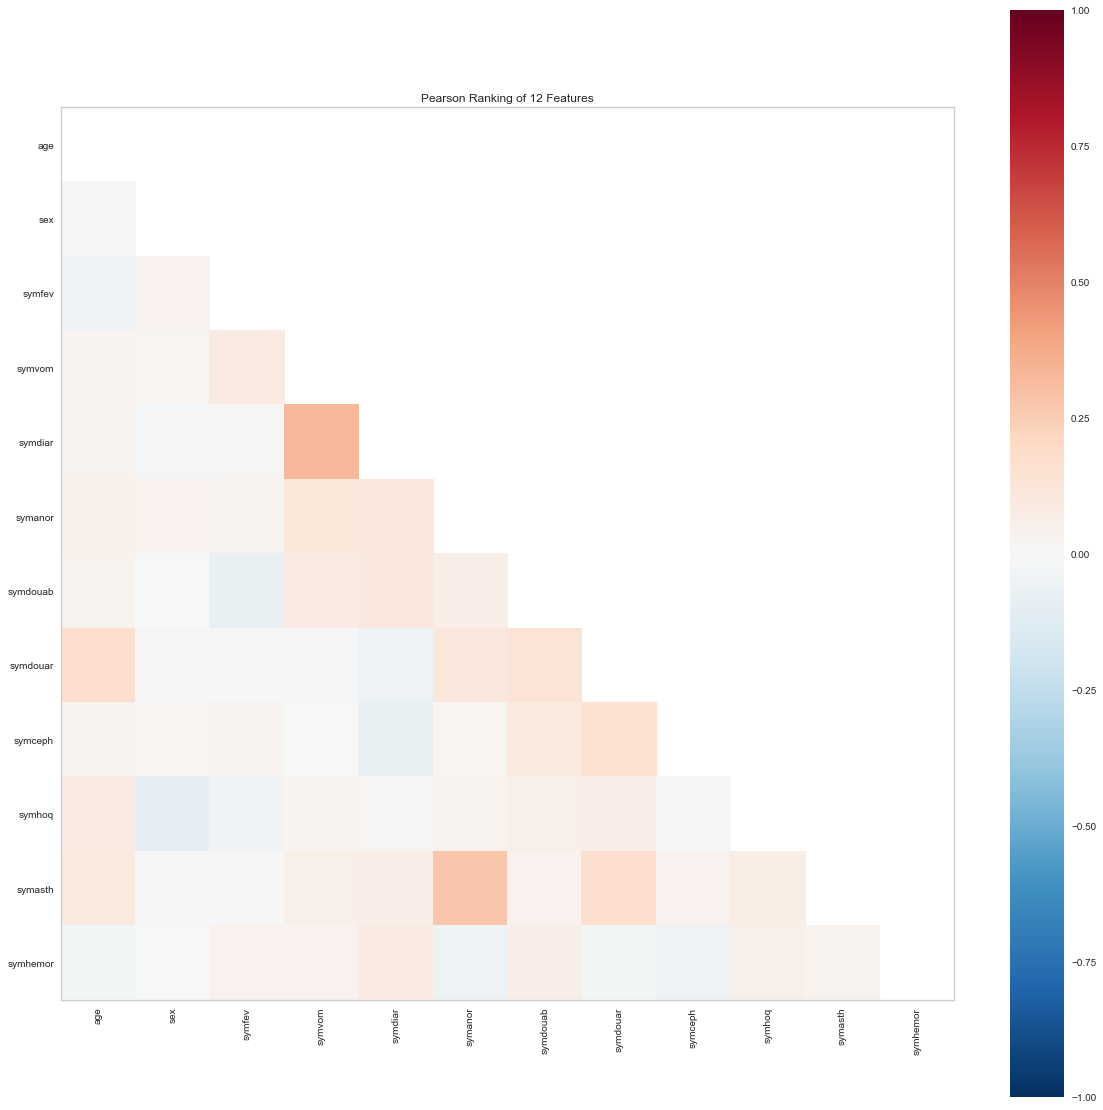

In [14]:
Corr_vision(X_ebo_simple)

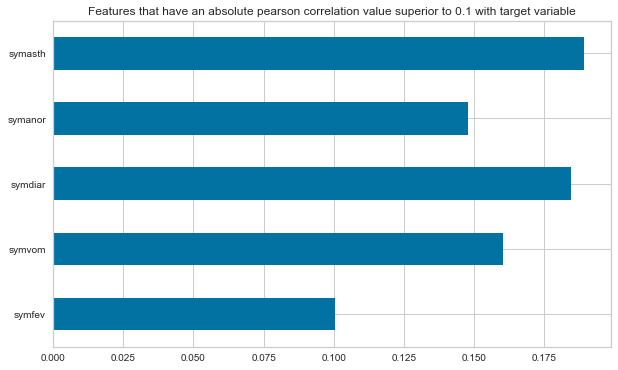

In [15]:
X_y = X_ebo_simple.join(y_ebo_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.1  
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

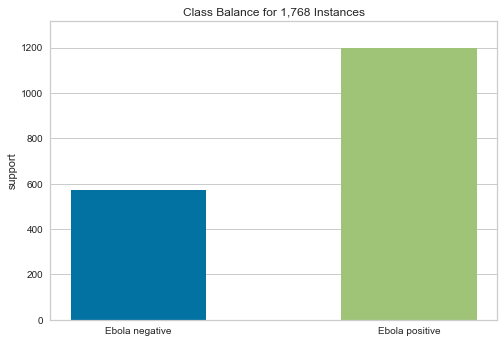

In [16]:
Imbalance(y_ebo_simple)

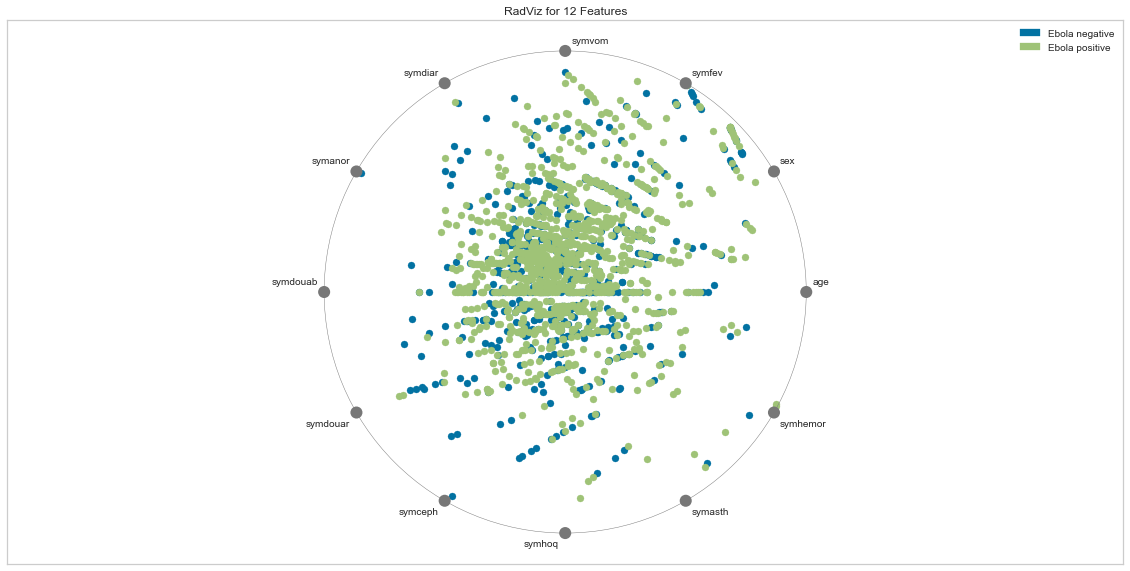

In [17]:
Rad_vision(X_ebo_simple, y_ebo_simple)

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


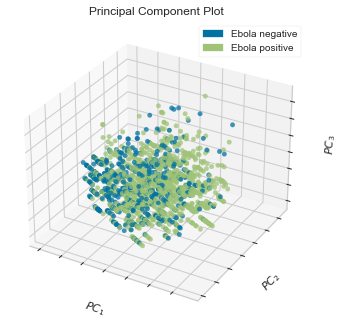

In [18]:
PCA_vision_3D(X_ebo_simple, y_ebo_simple.astype('int'))

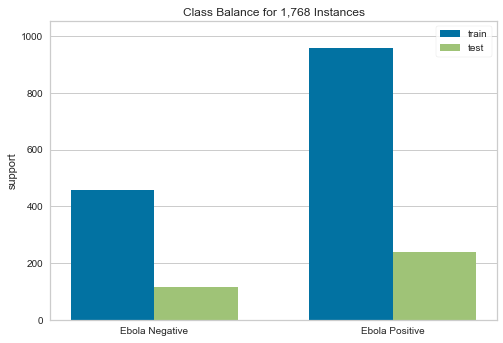

In [20]:

X_ebo_simple_train, X_ebo_simple_test, y_ebo_simple_train, y_ebo_simple_test = train_test_split(X_ebo_simple, y_ebo_simple, test_size=0.2, random_state=123, stratify=y_ebo_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_simple_train, y_ebo_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [347]:
# standardize age for df_ebo_simple

scaler1 = StandardScaler()
X_ebo_simple_train['age'] = scaler1.fit_transform(X_ebo_simple_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_simple_test['age'] = scaler1.transform(X_ebo_simple_test['age'].to_numpy().reshape(-1, 1))

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## ML models here

#### Decision tree

In [22]:
simple_decision_tree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [25]:
gsearch = GridSearchCV(
    estimator= simple_decision_tree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_simple_train, y_ebo_simple_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10, 

In [27]:
clf_best_simple_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_simple_tree.fit(X_ebo_simple_train, y_ebo_simple_train)
y_ebo_simple_pred = clf_best_simple_tree.predict(X_ebo_simple_test)
accuracy_all(y_ebo_simple_test, y_ebo_simple_pred)

Macro F1 score(test):  0.6175925925925926
Micro F1 score(test):  0.7231638418079096
Accuracy under curve(test):  0.6139254385964912


#### Random forest 

In [28]:
param_test = {
    'n_estimators':[20, 30, 40 , 50, 60, 100],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}
simple_random_forest = RandomForestClassifier(random_state = 123)

In [30]:
gsearch = GridSearchCV(
    estimator= simple_random_forest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_simple_train, y_ebo_simple_train)
print(gsearch.best_params_)

{'max_depth': 8, 'max_leaf_nodes': 15, 'min_samples_split': 6, 'n_estimators': 100}


In [31]:
best_simple_random_forest = RandomForestClassifier(
    random_state= 123,
    n_estimators=     gsearch.best_params_['n_estimators'], 
    max_depth=        gsearch.best_params_['max_depth'], 
    min_samples_split=gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=   gsearch.best_params_['max_leaf_nodes']
)
best_simple_random_forest = best_simple_random_forest.fit(X_ebo_simple_train, y_ebo_simple_train)
y_ebo_simple_pred = best_simple_random_forest.predict(X_ebo_simple_test)
accuracy_all(y_ebo_simple_test, y_ebo_simple_pred)

Macro F1 score(test):  0.5616345829111786
Micro F1 score(test):  0.7203389830508474
Accuracy under curve(test):  0.5796052631578947


## Second proposition of data frame

In [32]:
df_ebo_extra = df_ebo
# delete all rows where y = -1 :
df_ebo_extra = df_ebo_extra[df_ebo_extra['epistat']!=-1]
df_ebo_extra = make_indicators(df_ebo_extra, df_ebo_extra.drop('epistat', axis=1).columns, [-1]*len(df_ebo_extra.drop('epistat', axis=1).columns), False)
df_ebo_extra                                                                                                    

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,34.0,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y_ebo_extra = df_ebo_extra['epistat'].astype(float)
X_ebo_extra = df_ebo_extra.drop(['epistat'], axis = 1).astype(float)

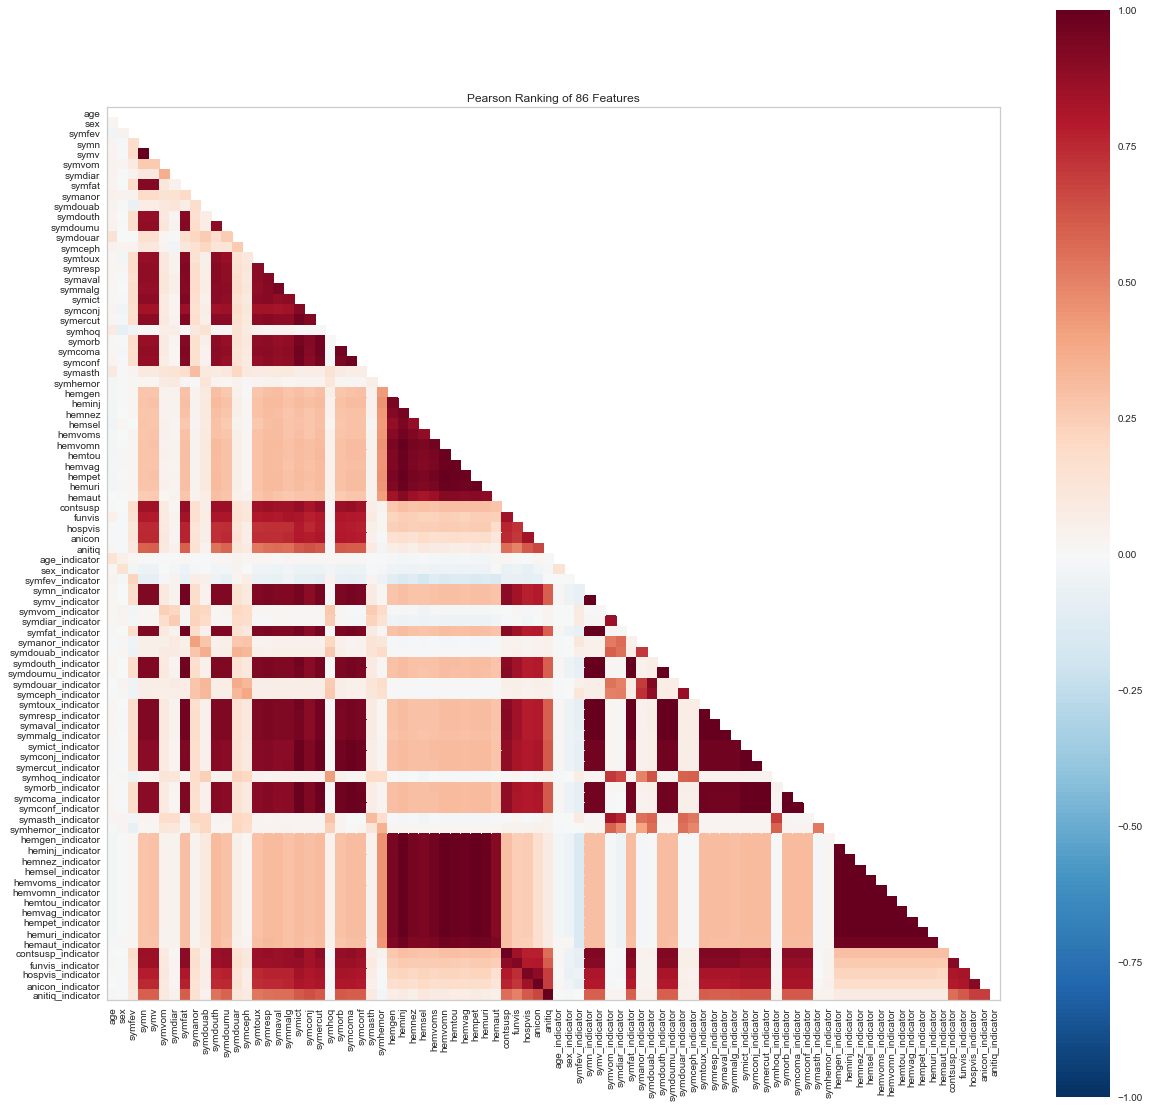

In [34]:
Corr_vision(X_ebo_extra)

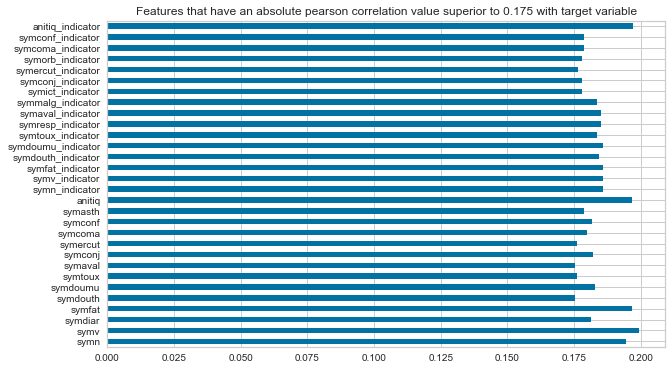

In [35]:
X_y = X_ebo_extra.join(y_ebo_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.175
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

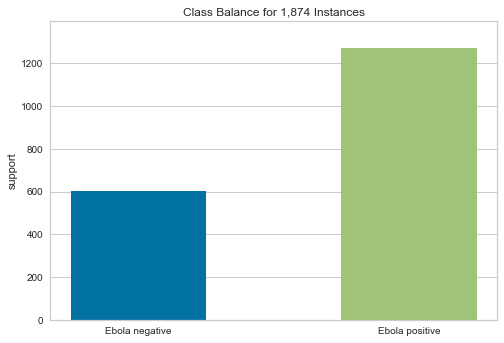

In [36]:
Imbalance(y_ebo_extra)

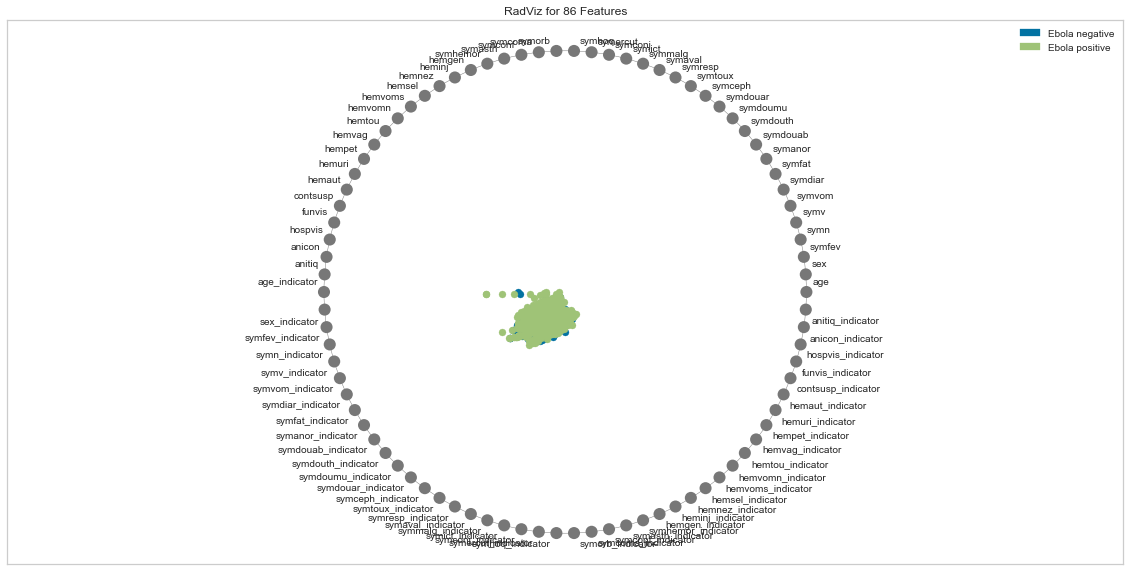

In [37]:
Rad_vision(X_ebo_extra, y_ebo_extra)

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


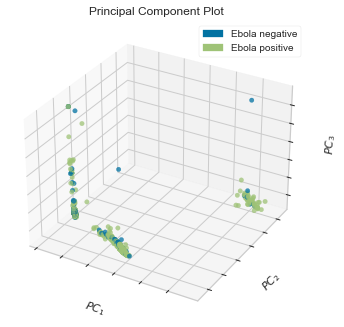

In [38]:
PCA_vision_3D(X_ebo_extra, y_ebo_extra.astype('int'))

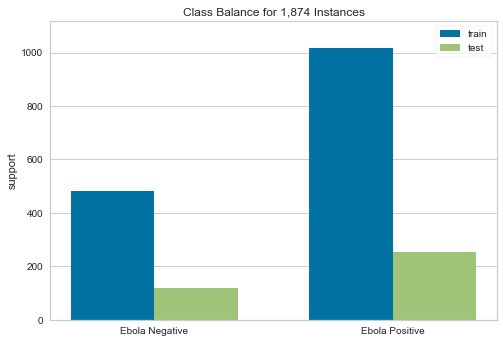

In [39]:
X_ebo_extra_train, X_ebo_extra_test, y_ebo_extra_train, y_ebo_extra_test = train_test_split(X_ebo_extra, y_ebo_extra, test_size=0.2, random_state=123, stratify=y_ebo_extra)

# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_extra_train, y_ebo_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [42]:
## standardize age

# change -1 to Nan so that it is not take into account when doing standardization 
X_ebo_extra_train['age'].replace(-1, np.nan, inplace=True)
X_ebo_extra_test['age'].replace(-1, np.nan, inplace=True)

# standardization
scaler2 = StandardScaler()
X_ebo_extra_train['age'] = scaler2.fit_transform(X_ebo_extra_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_extra_test['age'] = scaler2.transform(X_ebo_extra_test['age'].to_numpy().reshape(-1, 1))

# we can rechange nans to -1 
X_ebo_extra_train['age'].replace(np.nan, -1, inplace=True)
X_ebo_extra_test['age'].replace(np.nan, -1, inplace=True)

C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [43]:
# sanity check 
print(sum(X_ebo_extra_train['age_indicator']==0))
print(sum(X_ebo_extra_train['age']==-1))

8
8


## ML models here

In [44]:
extra_decision_tree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [45]:
gsearch = GridSearchCV(
    estimator= extra_decision_tree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_extra_train, y_ebo_extra_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10, 

In [46]:
clf_best_extra_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_extra_tree.fit(X_ebo_extra_train, y_ebo_extra_train)
y_ebo_extra_pred = clf_best_extra_tree.predict(X_ebo_extra_test)
accuracy_all(y_ebo_extra_test, y_ebo_extra_pred)

Macro F1 score(test):  0.5532245532245532
Micro F1 score(test):  0.6933333333333334
Accuracy under curve(test):  0.5649509803921569


## Third proposition of data frame

In [48]:
df_rid = pd.read_csv("../../../../Data_project2/part_2/Rid_frame.csv")

df_rid

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,G995,30.0,-1,-1,0,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1
1717,G996,43.0,-1,261,1,0,0,0,0,1,...,0,1,0,1,0,-1,0,1,0,1
1718,G997,34.0,-1,262,0,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,0
1719,G998,6.0,-1,260,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1


In [49]:
# For ridha's dataframe for yeah 
X_ebo_ml = df_rid.drop(columns = ['msfid','epistat'])
y_ebo_ml = df_rid['epistat']

#### Correlation matrix 

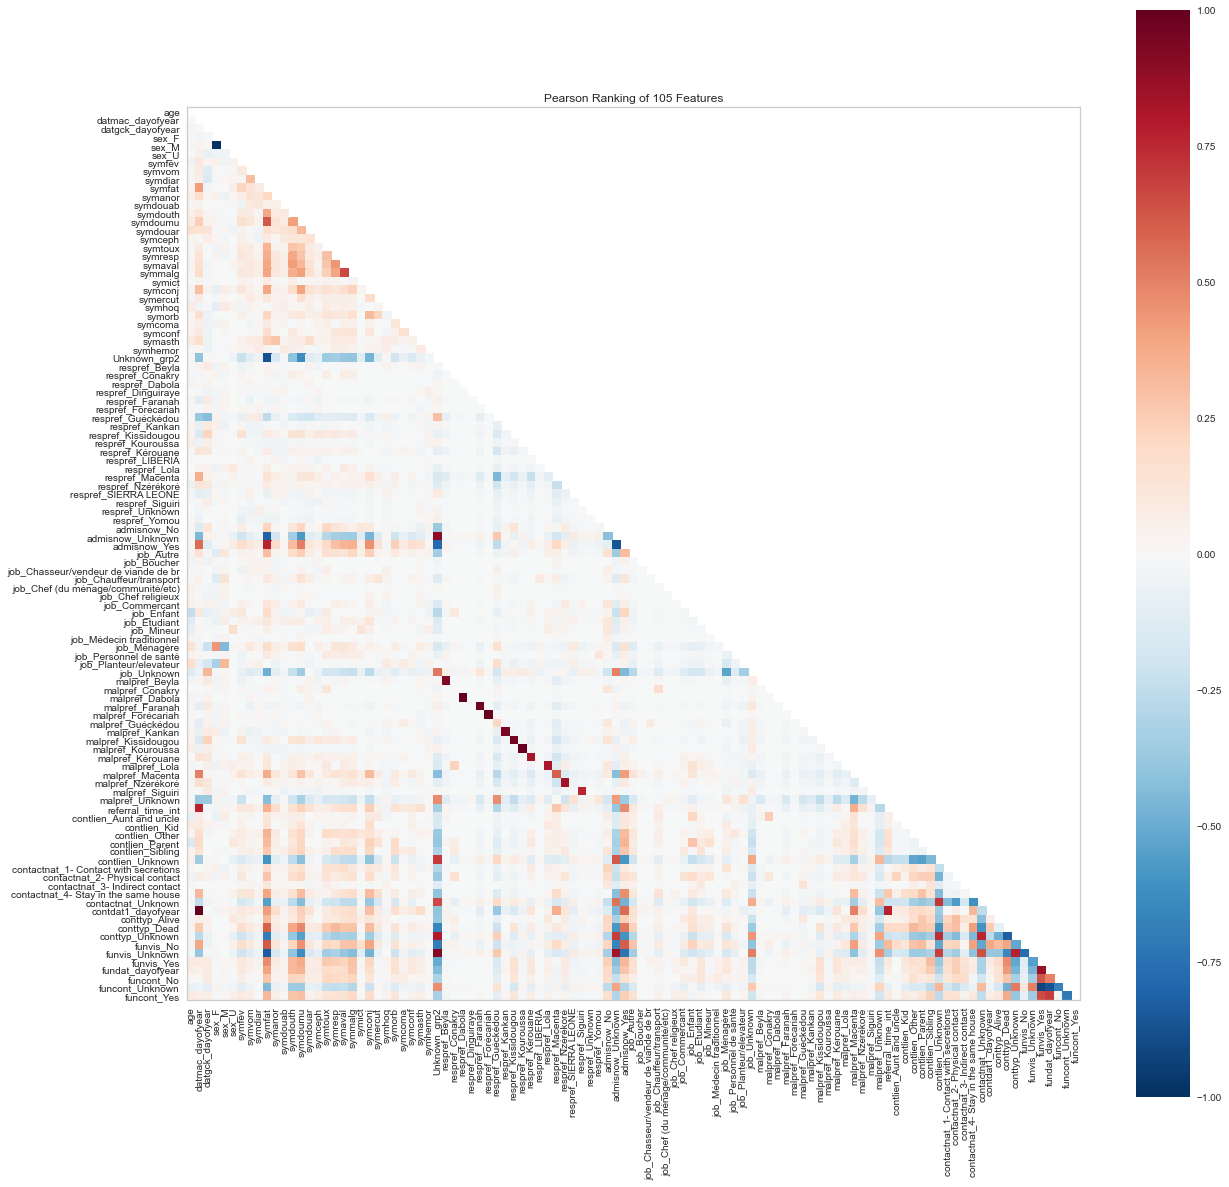

In [50]:
Corr_vision(X_ebo_ml)

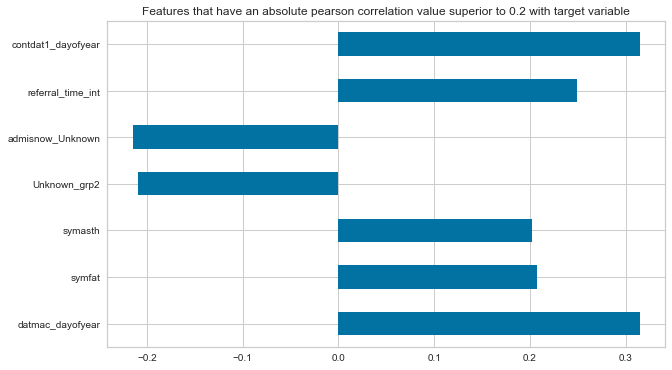

In [51]:
X_y = X_ebo_ml.join(y_ebo_ml)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.2
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

The values above are "correlated" with the output variable 'epistat' (ebola outcome), we expect them to be considered important during the model.

### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

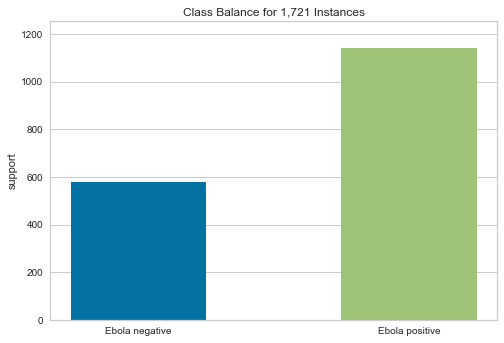

In [52]:
Imbalance(y_ebo_ml)

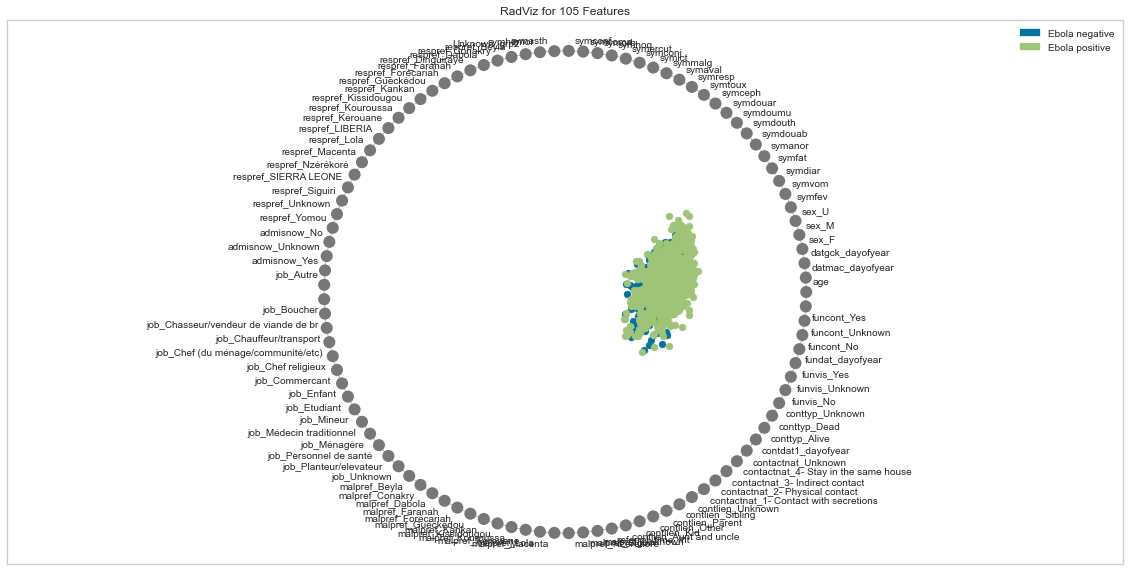

In [53]:
Rad_vision(X_ebo_ml, y_ebo_ml)

In [54]:
X_ebo_ml['respref_Dinguiraye'].value_counts()

0    1720
1       1
Name: respref_Dinguiraye, dtype: int64

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


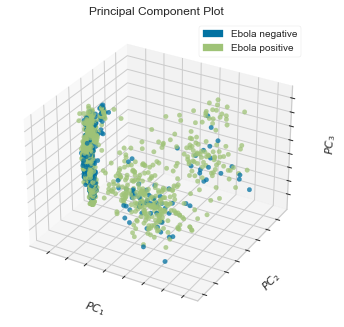

In [55]:
PCA_vision_3D(X_ebo_ml, y_ebo_ml)

#### How to interpret this 
Jean, Cdeic ? 

#### We are in a high dimension dataset, let's try Manifold

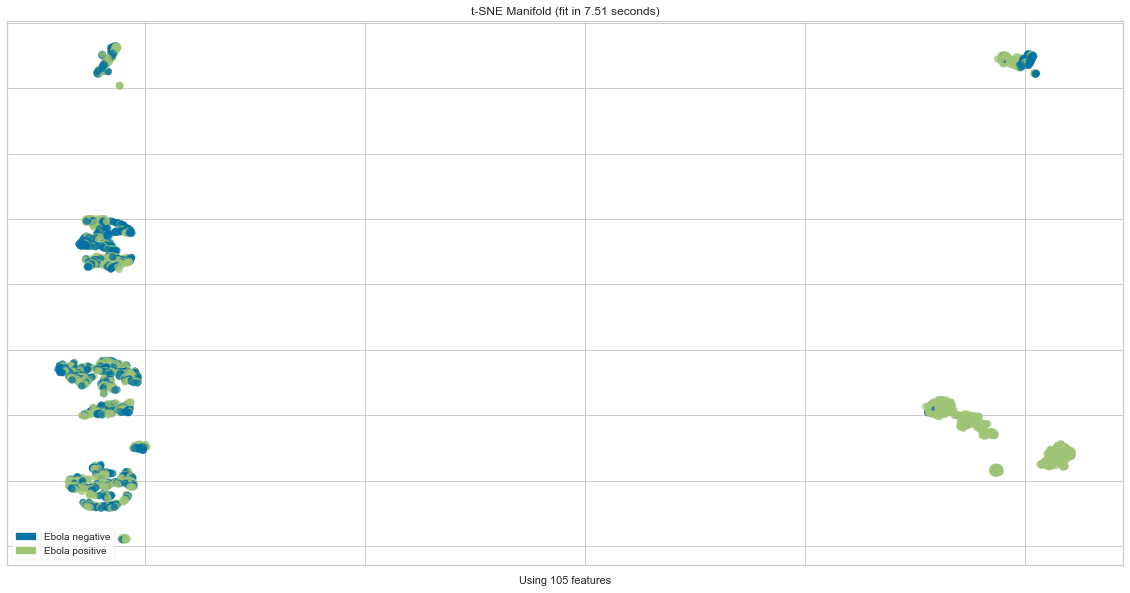

In [56]:
fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Ebola negative', 'Ebola positive'])
viz.fit_transform(X_ebo_ml, y_ebo_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

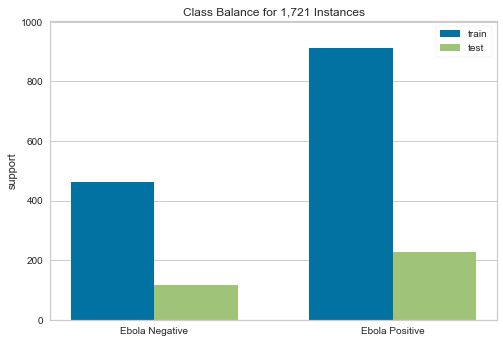

In [57]:

X_ebo_train, X_ebo_test, y_ebo_train, y_ebo_test = train_test_split(X_ebo_ml, y_ebo_ml, test_size=0.2, random_state=123, stratify=y_ebo_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_train, y_ebo_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [58]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_ebo_train.loc[:,numerical_col] = scaler3.fit_transform(X_ebo_train[numerical_col])
X_ebo_test.loc[:,numerical_col] = scaler3.transform(X_ebo_test[numerical_col])

C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### A quick logistic regression 

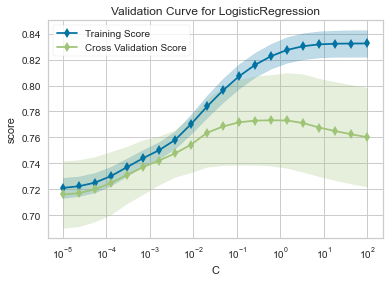

In [134]:
# Create the validation curve visualizer
cv = StratifiedKFold(5, random_state=123)
param_range = np.logspace(-5, 2, 20)

viz = ValidationCurve(LogisticRegression(), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [135]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-1, 0, 20)}
logit = LogisticRegression()

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_ebo_train, y_ebo_train)
clf.best_params_

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 0.6158482110660264, 'penalty': 'l1'}

In [136]:
logit = LogisticRegression(penalty = clf.best_params_['penalty'], C = clf.best_params_['C'])
logit.fit(X_ebo_train, y_ebo_train)
y_log_pred = logit.predict(X_ebo_test)
accuracy_all(y_ebo_test, y_log_pred)

Macro F1 score(test):  0.6527394015946949
Micro F1 score(test):  0.7043478260869566
Accuracy under curve(test):  0.6475493148622196


C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Decision tree

In [137]:
clftree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 5)]
}

In [138]:
gsearch = GridSearchCV(
    estimator= clftree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_train, y_ebo_train)
print(gsearch.best_params_)

{'max_depth': 5, 'min_samples_split': 2}


In [139]:
clf_best_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=gsearch.best_params_['max_depth'], 
    min_samples_split=gsearch.best_params_['min_samples_split'])
clf_best_tree.fit(X_ebo_train, y_ebo_train)
y_ebo_pred = clf_best_tree.predict(X_ebo_test)
accuracy_all(y_ebo_test, y_ebo_pred)

Macro F1 score(test):  0.6434701341648619
Micro F1 score(test):  0.6666666666666666
Accuracy under curve(test):  0.6531960548110224


### Random Forest 

    Use of validation curve to determine a plausible area for the hyper-parameters
- n_estimators: Number of trees to build
- max_depth: Maximum depth of tree
- min_samples_split: Data points in nodes before split occurs 

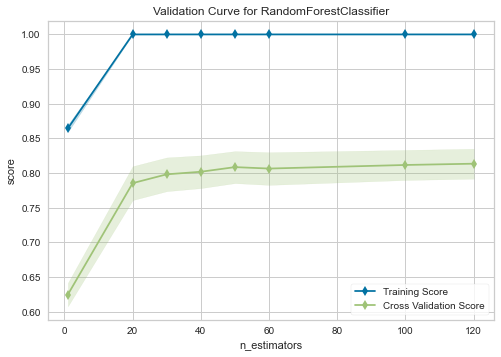

In [64]:
# For n_estimators

cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()



For n_estimators, we take the range where cross validation is good,
in this case [20-100]

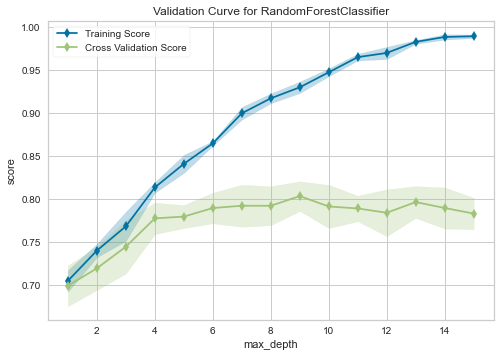

In [65]:
# For max_depth
param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()



For max_depth, range [6-14]

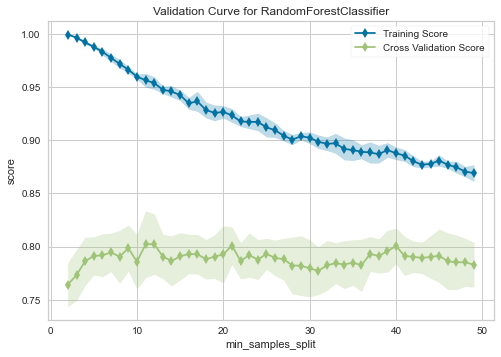

In [67]:
# For min_samples_split

param_range = range(2,50)

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()


Range from [2-25] for min_samples_split

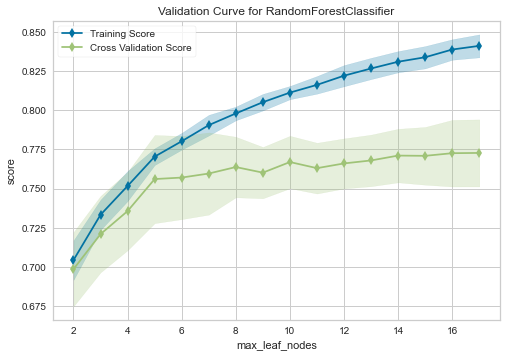

In [69]:
# For max_leaf_nodes
param_range = [2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15,16,17]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()



For max_leaf_nodes
range [6-16]

#### Hyperparameter tuning for random forest

Now that we have found ranges for the parameters, let's proceed with a cross validation.
Please bare in mind, that these ranges above were given for one hyper-parameter, when combined with multiple others, we should enlarge the range of each one.


In [70]:


parameters = {'n_estimators': [20,30, 40,50,60,100], 'max_depth' : [5,6, 7, 8, 9, 10,11,12,13,14],
              'min_samples_split': range(2,15), 'max_leaf_nodes': range(6,12)}

ebo_forest_classifier = RandomForestClassifier(random_state=123)
clf = GridSearchCV(ebo_forest_classifier, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_ebo_train, y_ebo_train)

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_gri

In [71]:
# Best parameters to introduce into new model 
clf.best_params_


{'max_depth': 9,
 'max_leaf_nodes': 11,
 'min_samples_split': 2,
 'n_estimators': 40}

RandomForestClassifier:
On training we get an Accuracy 0.721656976744186, an AUC 0.5994593163944344 and F1 score 0.8227672373900972 
For test we get an Accuracy 0.6927536231884058, an AUC 0.5686267128444512 and F1 score 0.8037037037037037


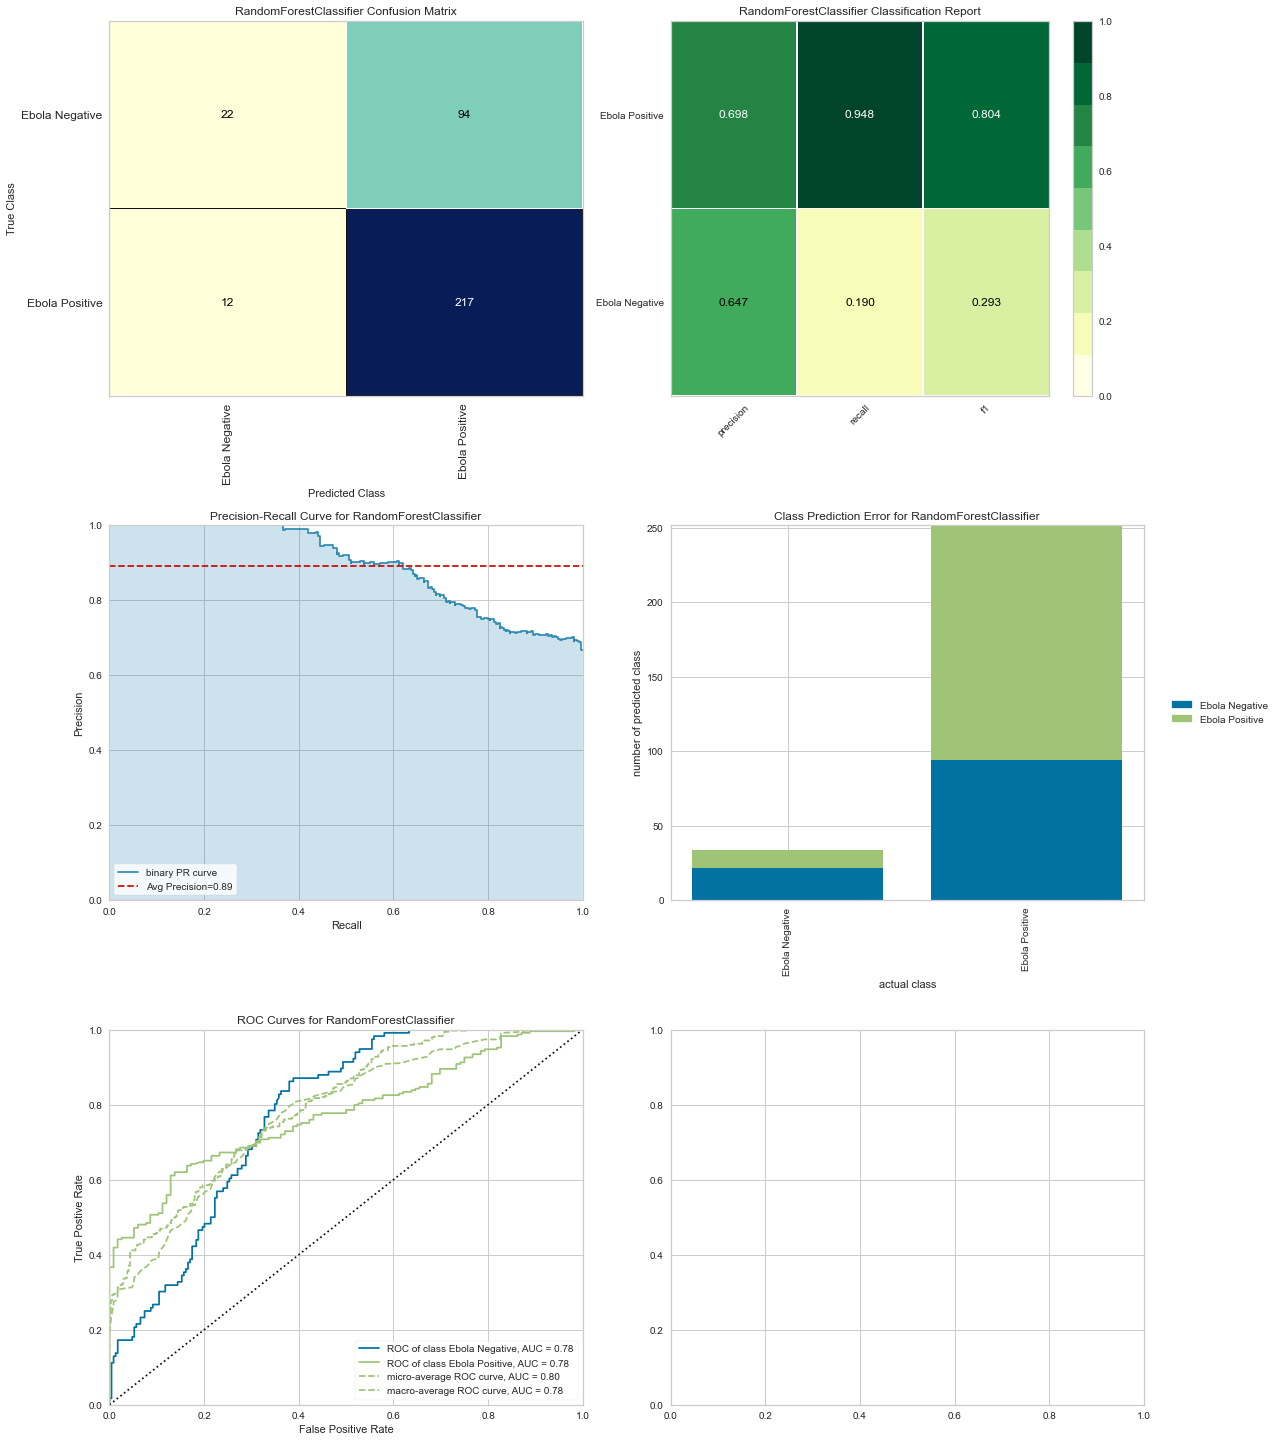

Don't have feature importance




In [72]:
ebo_forest_classifier = RandomForestClassifier(
    random_state=123,
    n_estimators =      clf.best_params_['n_estimators'],
    max_depth =         clf.best_params_['max_depth'],
    min_samples_split = clf.best_params_['min_samples_split'],
    max_leaf_nodes =    clf.best_params_['max_leaf_nodes']
)

# Give score to model
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, ebo_forest_classifier)

### SVM

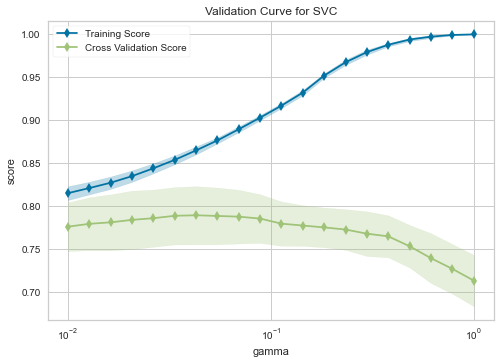

In [73]:
# Validation curve for gamma parameter 
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

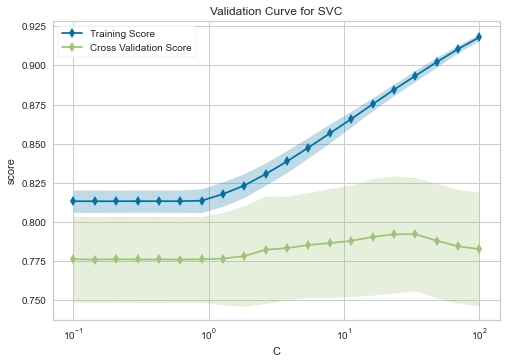

In [74]:
# Validation curve for C parameter 
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-1, 2, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [75]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(1, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_ebo_train, y_ebo_train)

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([ 10.        ,  10.82636734,  11.721022...
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return

In [76]:
clf.best_params_

{'C': 10.0, 'gamma': 0.01610262027560939, 'kernel': 'rbf'}

SVC:
On training we get an Accuracy 0.8037790697674418, an AUC 0.7773366606170599 and F1 score 0.8529411764705882 
For test we get an Accuracy 0.7275362318840579, an AUC 0.6947937057672037 and F1 score 0.7947598253275109
Can plot ROC curve for this model
Don't have feature importance


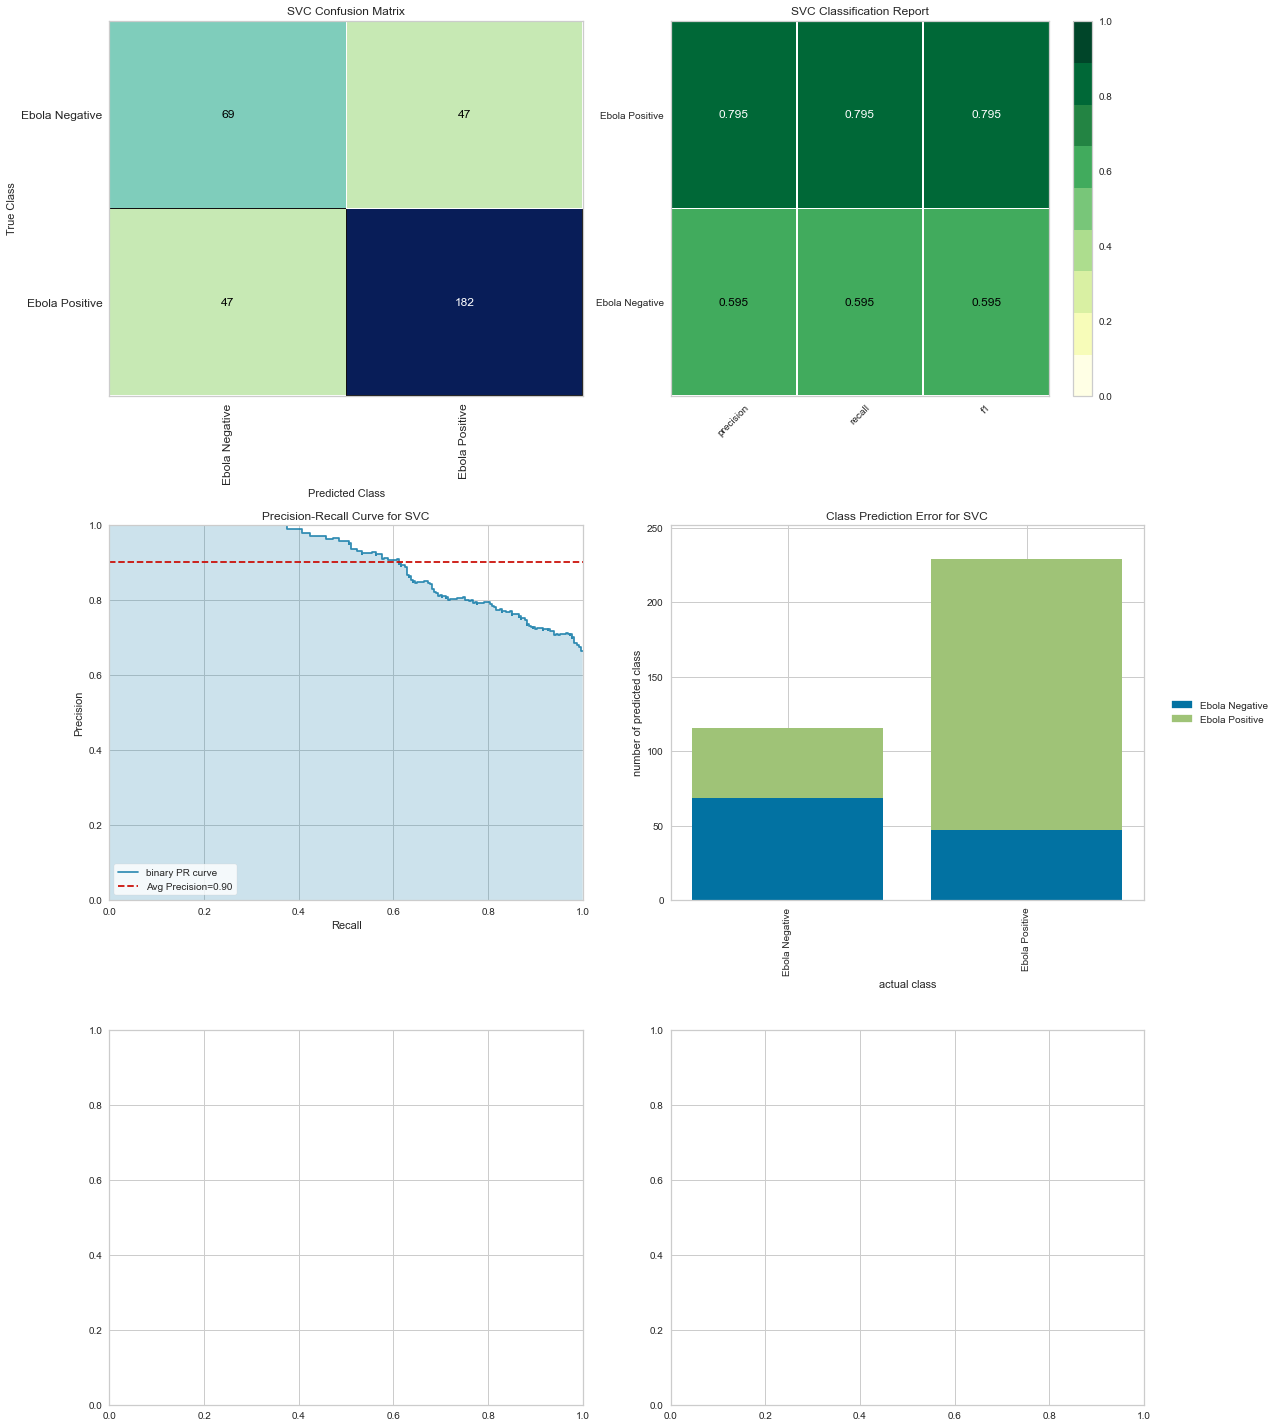

In [77]:
svc = svm.SVC(
    random_state = 123,
    C =      clf.best_params_['C'], 
    gamma =  clf.best_params_['gamma'], 
    kernel = clf.best_params_['kernel'])
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, svc)

In [78]:
############################################################################################################################################

# Predictions outcome

### Outcome 

In [79]:
# apply dictionnary to get -1, 0, 1 for df_outcome  --> 0: recovery, 1: death, -1: unknown
df_outcome  = df_linelist['outcome']
dict_outcome_answer = {'1':'0', '2':'1', '3':'-1', '4':'-1', '9':'-1', '.':'-1'}
df_outcome = df_outcome.astype('str')
df_outcome = df_outcome.apply(lambda x : dict_outcome_answer[x])

### Assemble

In [80]:
# concatenate symptoms, age, sex and outcome (also add epistat so that we only keep ebola positive people)
df_out = pd.concat([df_age, df_sex, df_symp, df_outcome, df_ebola], axis = 1, join = 'outer').astype('int')
df_out = df_out[df_out['epistat']!=0]
df_out = df_out[df_out['epistat']!=-1]
print(df_out['epistat'].value_counts())
df_out.drop('epistat', axis=1, inplace = True)

# add constant column --> only for linear regression, SVM, etc
#df_out = sm.add_constant(df_out).astype('int')
df_out

1    1507
Name: epistat, dtype: int64


,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60,0,1,-1,-1,1,0,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,35,0,1,-1,-1,1,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,40,1,1,-1,-1,0,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,40,1,1,-1,-1,0,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,8,0,1,-1,-1,0,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26,1,1,-1,-1,1,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2495,-1,0,0,-1,-1,1,1,-1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2496,43,1,0,-1,-1,0,1,-1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2498,6,1,1,-1,-1,0,0,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### Feature processing

In [81]:
# first convert all -1 to NaN so that we can use the dropna() function
df_out.replace(-1, np.nan, inplace=True)
# then drop columns with only nans 
df_out.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_out.replace(np.nan, -1, inplace=True)

# then do the same with zeros
df_out.replace(0, np.nan, inplace=True)
df_out.dropna(axis=0, how='all', subset=symptoms, inplace=True)
df_out.replace(np.nan, 0, inplace=True)

df_out 

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


## First proposition of data frame

In [82]:
df_out_simple = delete_minus1(df_out)
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,45.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [83]:
remaining_symptoms = ['symfev', 'symvom', 'symdiar', 'symanor', 'symdouab', 'symdouar', 
                      'symceph', 'symhoq', 'symasth', 'symhemor']

# then do the same with zeros
df_out_simple.replace(0, np.nan, inplace=True)
df_out_simple.dropna(axis=0, how='all', subset=remaining_symptoms, inplace=True)
df_out_simple.replace(np.nan, 0, inplace=True)
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,45.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [84]:
y_out_simple = df_out_simple['outcome'].astype(float)
X_out_simple = df_out_simple.drop(['outcome'], axis = 1).astype(float)

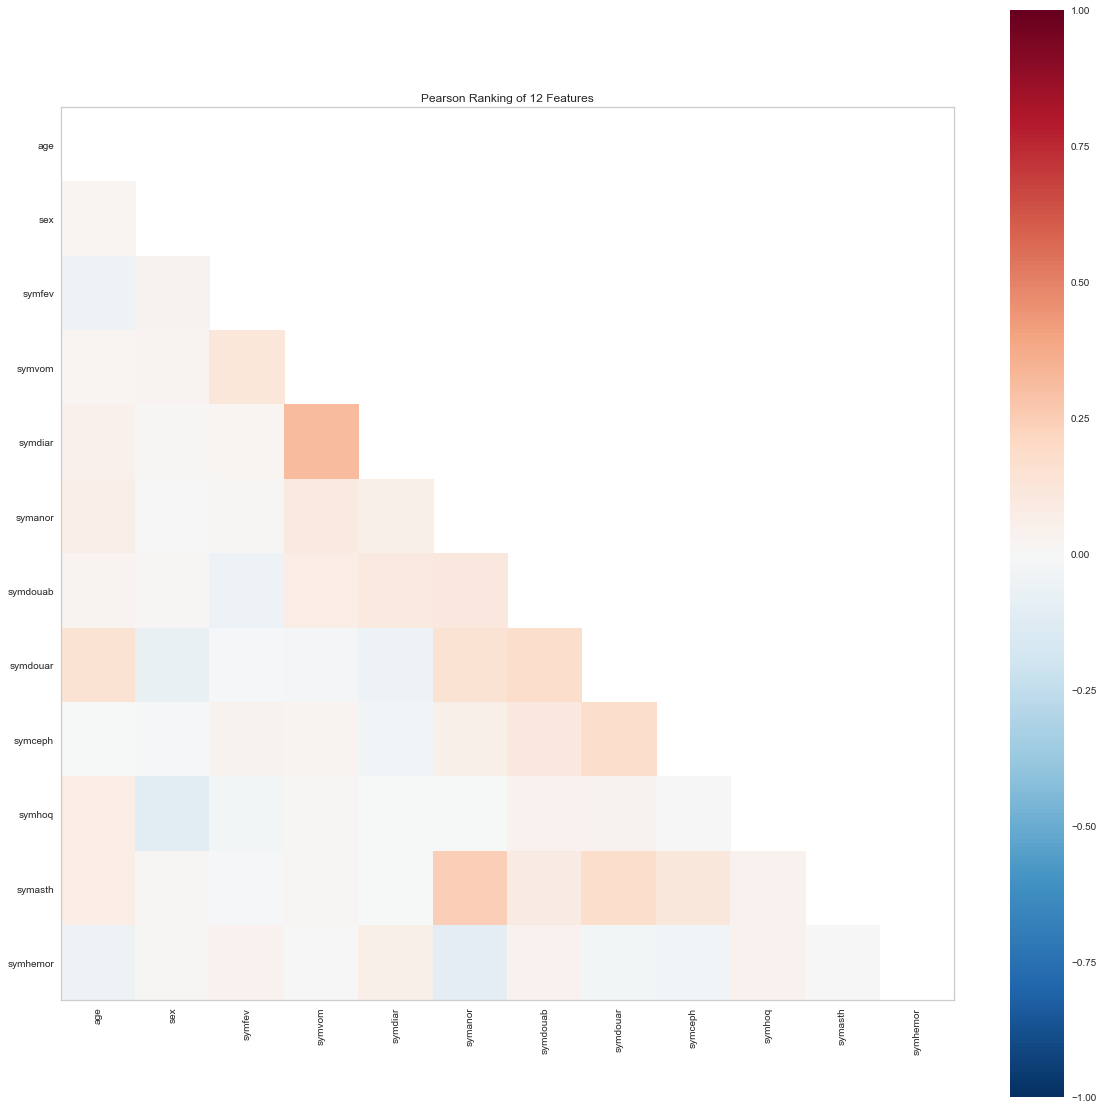

In [85]:
Corr_vision(X_out_simple)

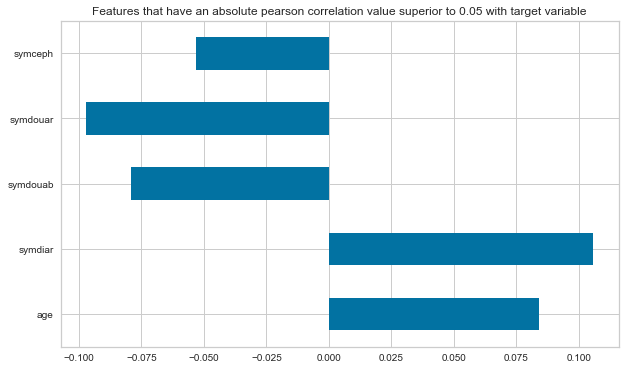

In [86]:
X_y = X_out_simple.join(y_out_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

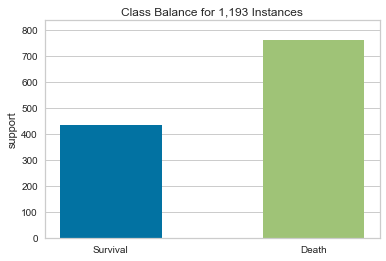

In [140]:
Imbalance_out(y_out_simple)

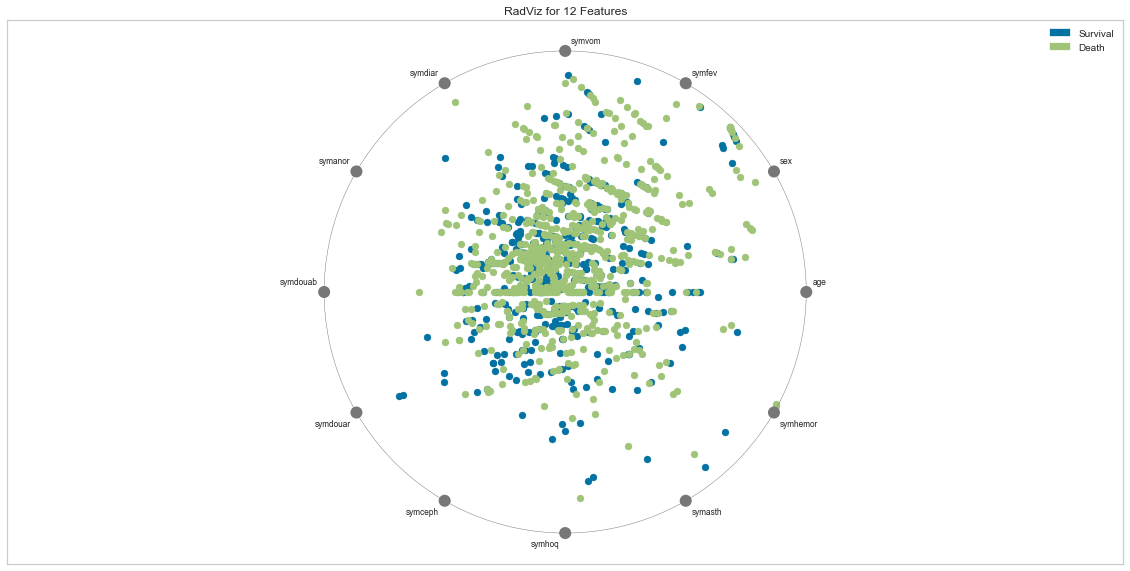

In [141]:
Rad_vision_out(X_out_simple, y_out_simple)

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


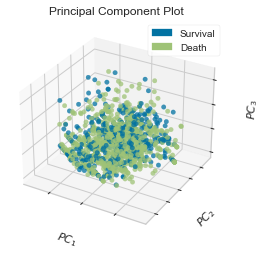

In [142]:
PCA_vision_3D_out(X_out_simple, y_out_simple.astype('int'))

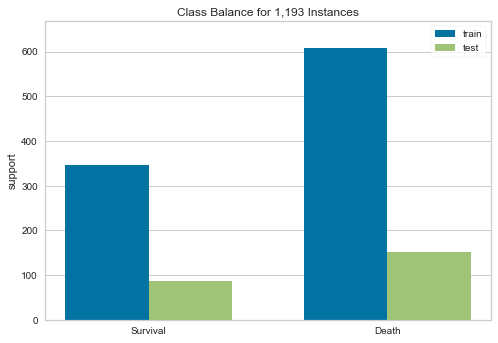

In [90]:
X_out_simple_train, X_out_simple_test, y_out_simple_train, y_out_simple_test = train_test_split(X_out_simple, y_out_simple, test_size=0.2, random_state=123, stratify=y_out_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_simple_train, y_out_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [91]:
# standardize age for df_out_simple

scaler1 = StandardScaler()
X_out_simple_train['age'] = scaler1.fit_transform(X_out_simple_train['age'].to_numpy().reshape(-1, 1))  
X_out_simple_test['age'] = scaler1.transform(X_out_simple_test['age'].to_numpy().reshape(-1, 1))

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### ML models

## Second proposition of data frame

In [92]:
df_out_extra = df_out
df_out_extra = df_out_extra[df_out_extra['outcome']!=-1]     
# delete all rows where y = -1:
df_out_extra = make_indicators(df_out_extra, df_out_extra.drop('outcome', axis=1).columns, [-1]*len(df_out_extra.drop('outcome', axis=1).columns), False)   # apply Cédric's function
df_out_extra

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# sanity check 
print(sum(df_out_extra['age_indicator']==0))
print(sum(df_out_extra['age']==-1))

print(sum(df_out_extra['outcome']==0))
print(sum(df_out_extra['outcome']==1))

7
7
446
821


In [94]:
y_out_extra = df_out_extra['outcome'].astype(float)
X_out_extra = df_out_extra.drop(['outcome'], axis = 1).astype(float)

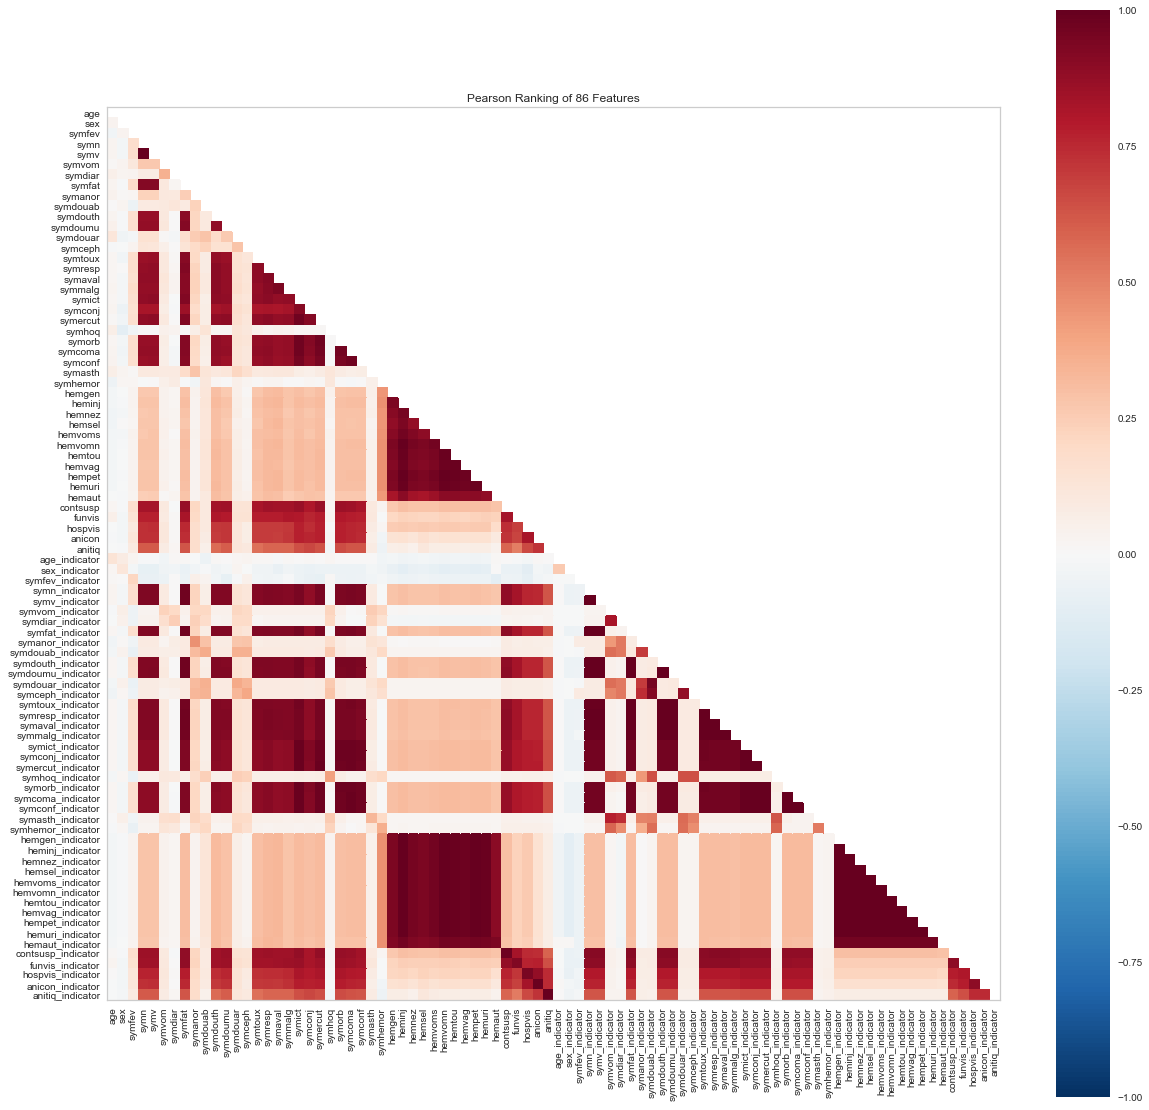

In [95]:
Corr_vision(X_out_extra)

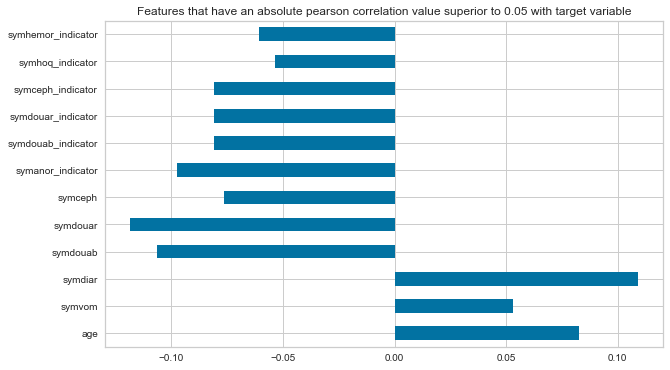

In [96]:
X_y = X_out_extra.join(y_out_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

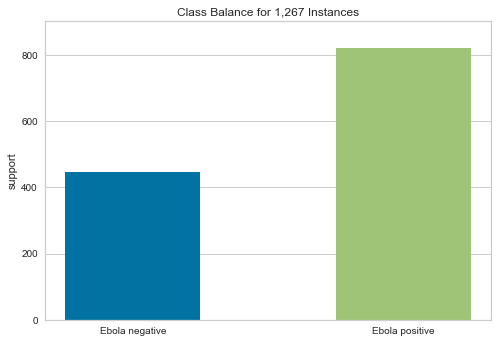

In [97]:
Imbalance_out(y_out_extra)

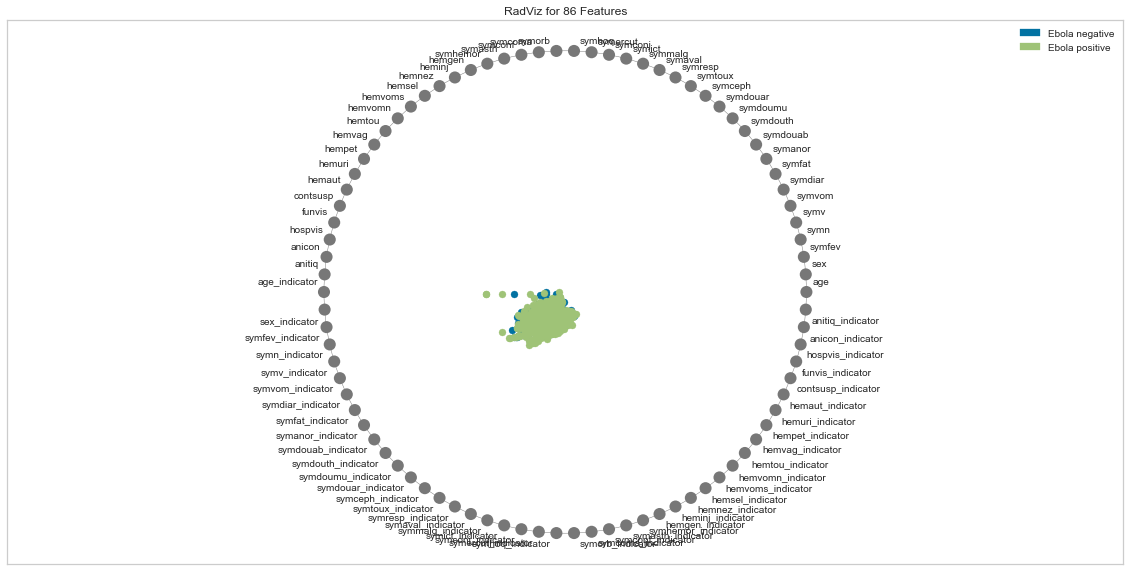

In [98]:
Rad_vision_out(X_out_extra, y_out_extra)

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


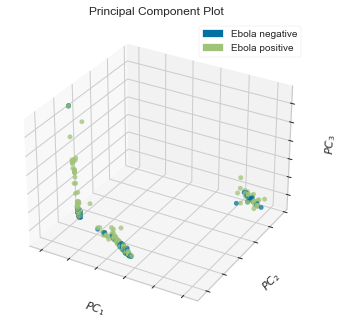

In [99]:
PCA_vision_3D_out(X_out_extra, y_out_extra.astype('int'))

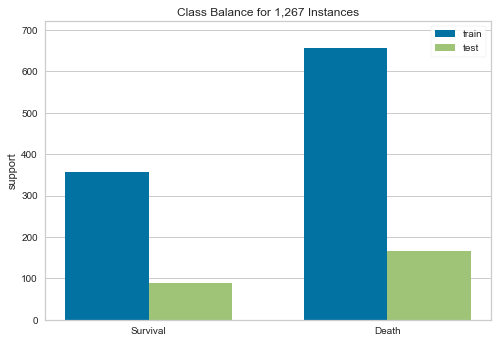

In [100]:
X_out_extra_train, X_out_extra_test, y_out_extra_train, y_out_extra_test = train_test_split(X_out_extra, y_out_extra, test_size=0.2, random_state=123, stratify=y_out_extra)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_extra_train, y_out_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [101]:
# standardize age for df_out_extra

scaler2 = StandardScaler()
X_out_extra_train['age'] = scaler1.fit_transform(X_out_extra_train['age'].to_numpy().reshape(-1, 1))  
X_out_extra_test['age'] = scaler1.transform(X_out_extra_test['age'].to_numpy().reshape(-1, 1))

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### ML model here

## Third proposition of data frame for outcome 

In [102]:
df_rid

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,G995,30.0,-1,-1,0,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1
1717,G996,43.0,-1,261,1,0,0,0,0,1,...,0,1,0,1,0,-1,0,1,0,1
1718,G997,34.0,-1,262,0,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,0
1719,G998,6.0,-1,260,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1


First concatenate df_outcome (cleaned, but we need to still remove -1 "the unknwons") with msfid, in order to merge with df_rid 



In [103]:
df_outcome = df_outcome.astype('int')
df_temp = pd.concat([df_outcome, df_linelist['msfid']], axis = 1, join = 'outer')
df_temp

,outcome,msfid
0,1,G1
1,1,G10
2,0,G100
3,1,G1000
4,1,G1001
...,...,...
2495,1,G995
2496,1,G996
2497,-1,G997
2498,1,G998


In [104]:
df_out_rid = df_temp[df_temp['outcome'] != -1]
df_out_rid = df_out_rid.merge(df_rid,on = 'msfid')
# We predict the outcome only on ebola postive people, by outcome we mean (dead, not dead)
df_out_rid['epistat'] =df_out_rid['epistat'].replace(0, np.nan)
df_out_rid.dropna(axis = 0, inplace = True)
df_out_rid

,outcome,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,1,G10,35.0,-1,-1,0,1,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1,0,G100,40.0,-1,101,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
2,1,G1000,40.0,260,-1,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
3,1,G1001,8.0,260,262,0,1,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
4,0,G1002,12.0,258,262,0,1,0,1,1,...,1,0,1,0,0,-1,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,G994,26.0,-1,261,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1166,1,G995,30.0,-1,-1,0,1,0,0,1,...,0,1,0,1,0,-1,0,1,0,1.0
1167,1,G996,43.0,-1,261,1,0,0,0,0,...,0,1,0,1,0,-1,0,1,0,1.0
1168,1,G998,6.0,-1,260,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0


In [105]:
# Let's drop msfid and epistat

df_out_rid.drop(['msfid','epistat'], inplace= True, axis = 1)


In [106]:
# This is now the third dataframe to predict the outcome knowing your patient is positive 
df_out_rid

,outcome,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Alive,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes
0,1,35.0,-1,-1,0,1,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1,0,40.0,-1,101,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0
2,1,40.0,260,-1,1,0,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
3,1,8.0,260,262,0,1,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
4,0,12.0,258,262,0,1,0,1,1,1,...,0,1,0,1,0,0,-1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,26.0,-1,261,1,0,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1166,1,30.0,-1,-1,0,1,0,0,1,1,...,0,0,1,0,1,0,-1,0,1,0
1167,1,43.0,-1,261,1,0,0,0,0,1,...,0,0,1,0,1,0,-1,0,1,0
1168,1,6.0,-1,260,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0


In [107]:
# For ridha's dataframe for yeah 
X_out_ml = df_out_rid.drop(columns = ['outcome'])
y_out_ml = df_out_rid['outcome']

#### We note that this column has only zero and we'll drop it

In [108]:
X_out_ml['respref_Dinguiraye'].value_counts()

0    1137
Name: respref_Dinguiraye, dtype: int64

In [109]:
X_out_ml.drop(columns=['respref_Dinguiraye'], inplace = True)

#### Correlation matrix 

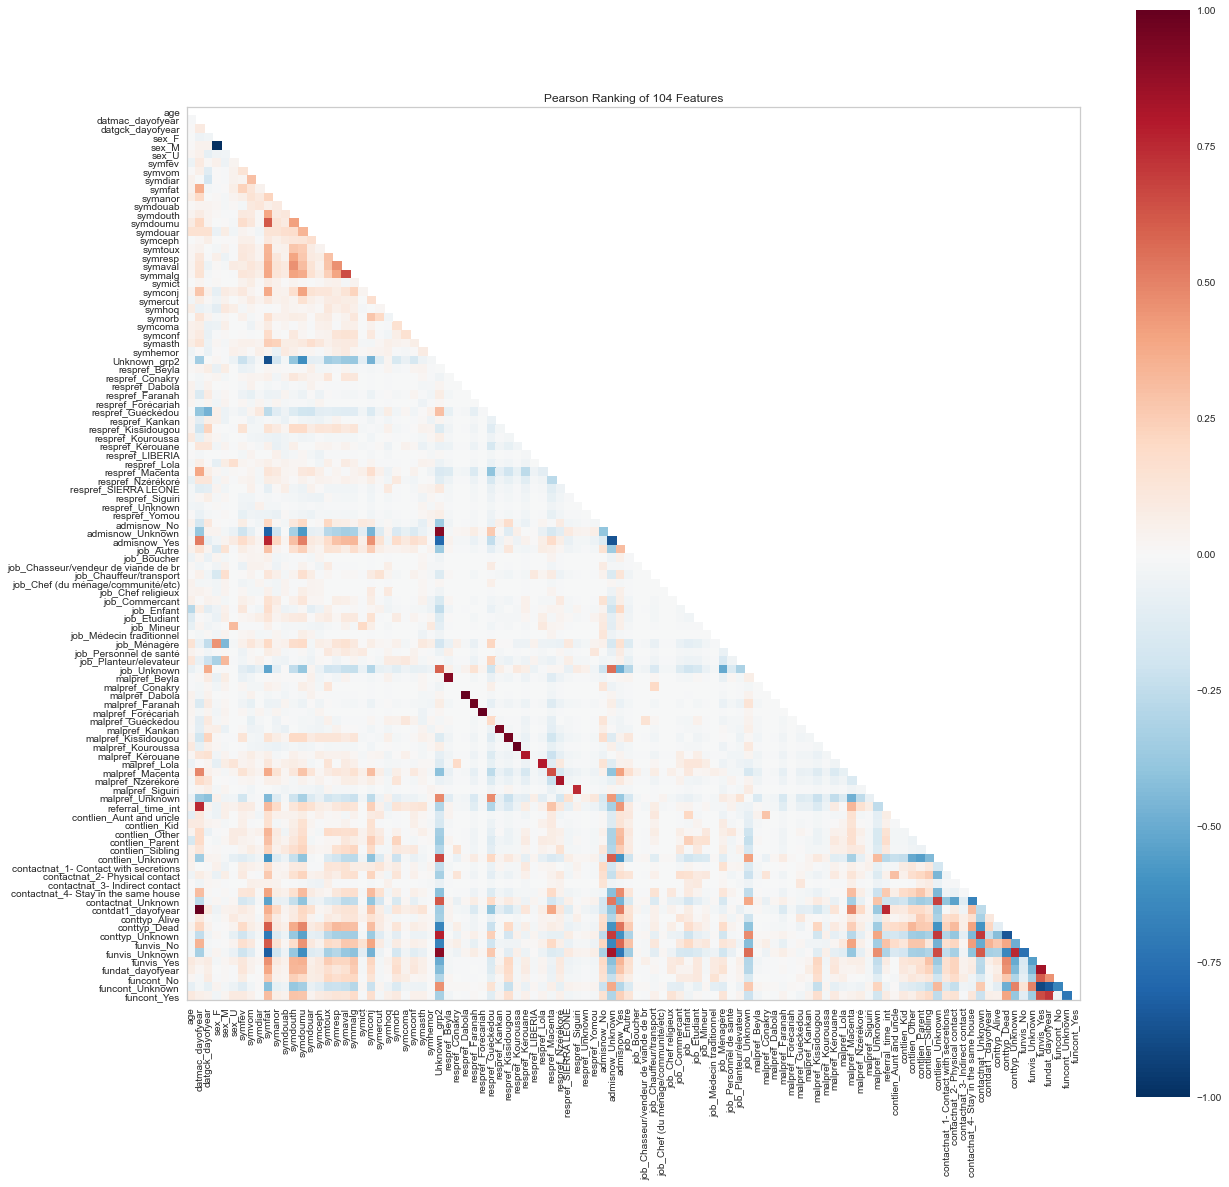

In [110]:
Corr_vision(X_out_ml)

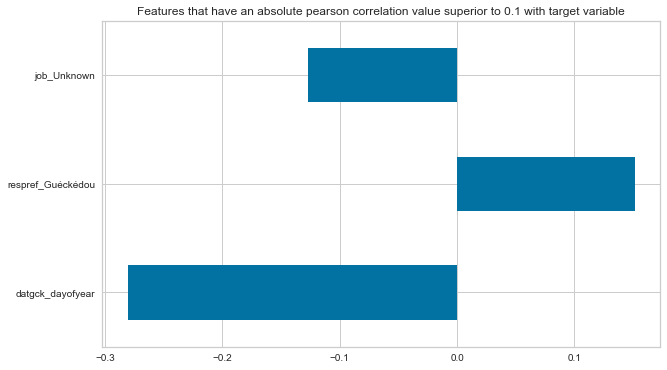

In [111]:
X_y_out = X_out_ml.join(y_out_ml, how = 'outer')
corr_matrix = X_y_out.corr()

corr_y = corr_matrix['outcome']
threshold = 0.1
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()



### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

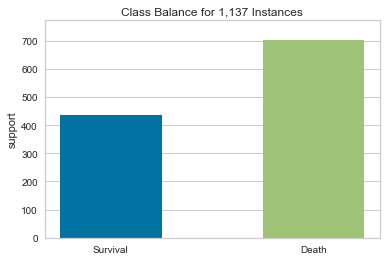

In [143]:
Imbalance_out(y_out_ml)

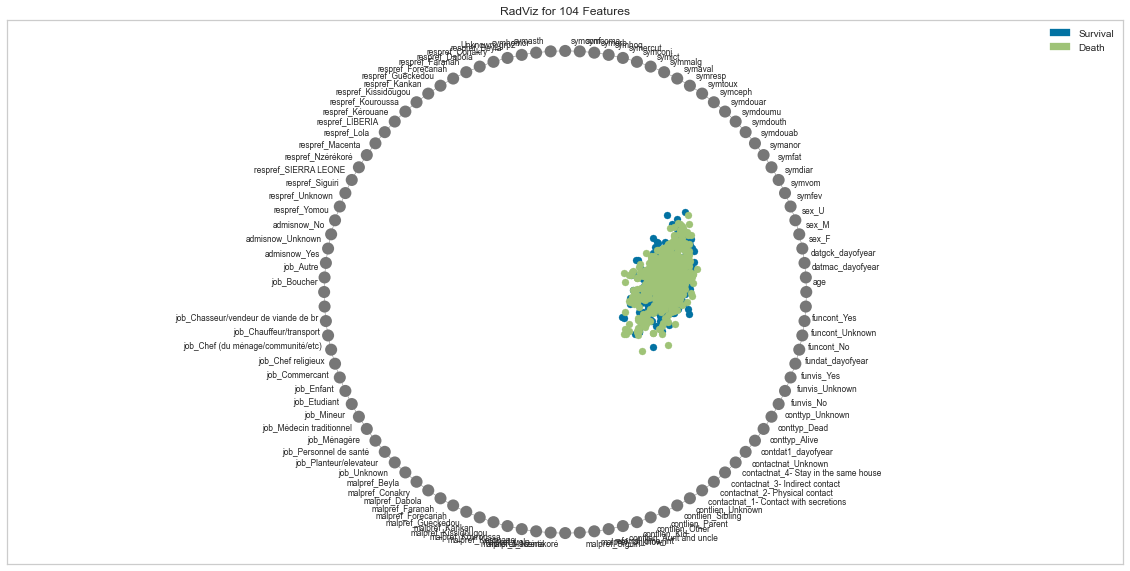

In [144]:
Rad_vision_out(X_out_ml, y_out_ml)

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

C:\Users\Cedric\Anaconda3\lib\site-packages\yellowbrick\features\pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


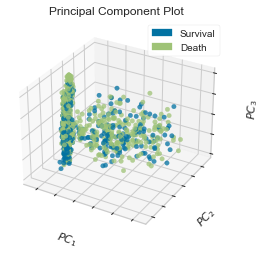

In [145]:
PCA_vision_3D_out(X_out_ml, y_out_ml)

#### We are in a high dimension dataset, let's try Manifold

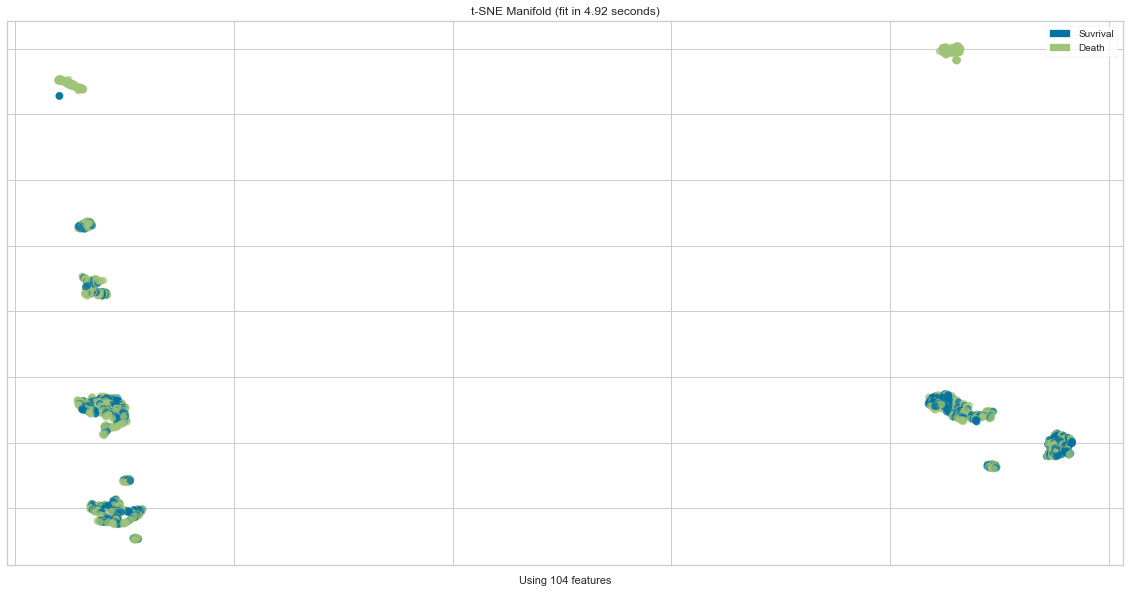

In [117]:
fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Suvrival', 'Death'])
viz.fit_transform(X_out_ml, y_out_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

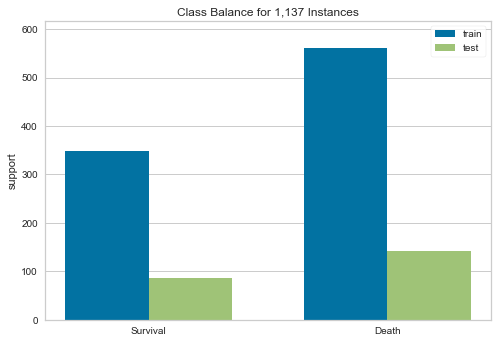

In [118]:

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out_ml, y_out_ml, test_size=0.2, random_state=123, stratify=y_out_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_train, y_out_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [119]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_out_train.loc[:,numerical_col] = scaler3.fit_transform(X_out_train[numerical_col])
X_out_test.loc[:,numerical_col] = scaler3.transform(X_out_test[numerical_col])

C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [120]:
########## The    data   is    now     normalized    ###################

## Jean and Ced, you can now use 

### SVM

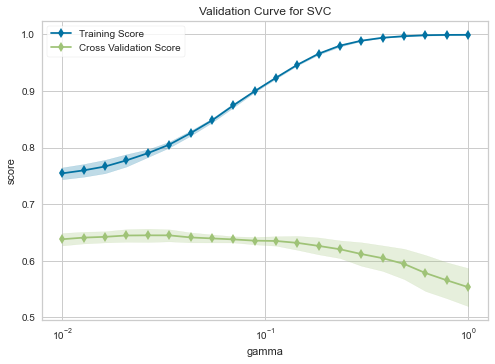

In [124]:
# Validation curve for gamma parameter 
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

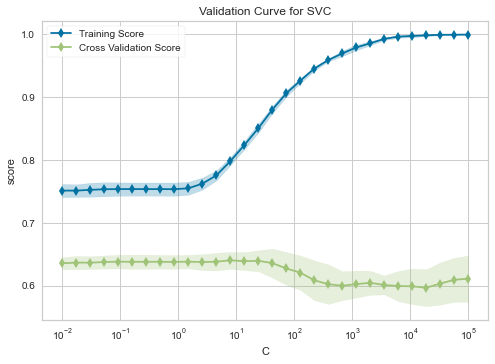

In [125]:
# Validation curve for C parameter 
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-2, 5, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [123]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_out_train, y_out_train)

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1....
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True

In [126]:
clf.best_params_

{'C': 1.0, 'gamma': 0.17433288221999882, 'kernel': 'rbf'}

SVC:
On training we get an Accuracy 0.8679867986798679, an AUC 0.8417696232097854 and F1 score 0.8991596638655464 
For test we get an Accuracy 0.5921052631578947, an AUC 0.5293470286133529 and F1 score 0.7066246056782334
Can plot ROC curve for this model
Don't have feature importance


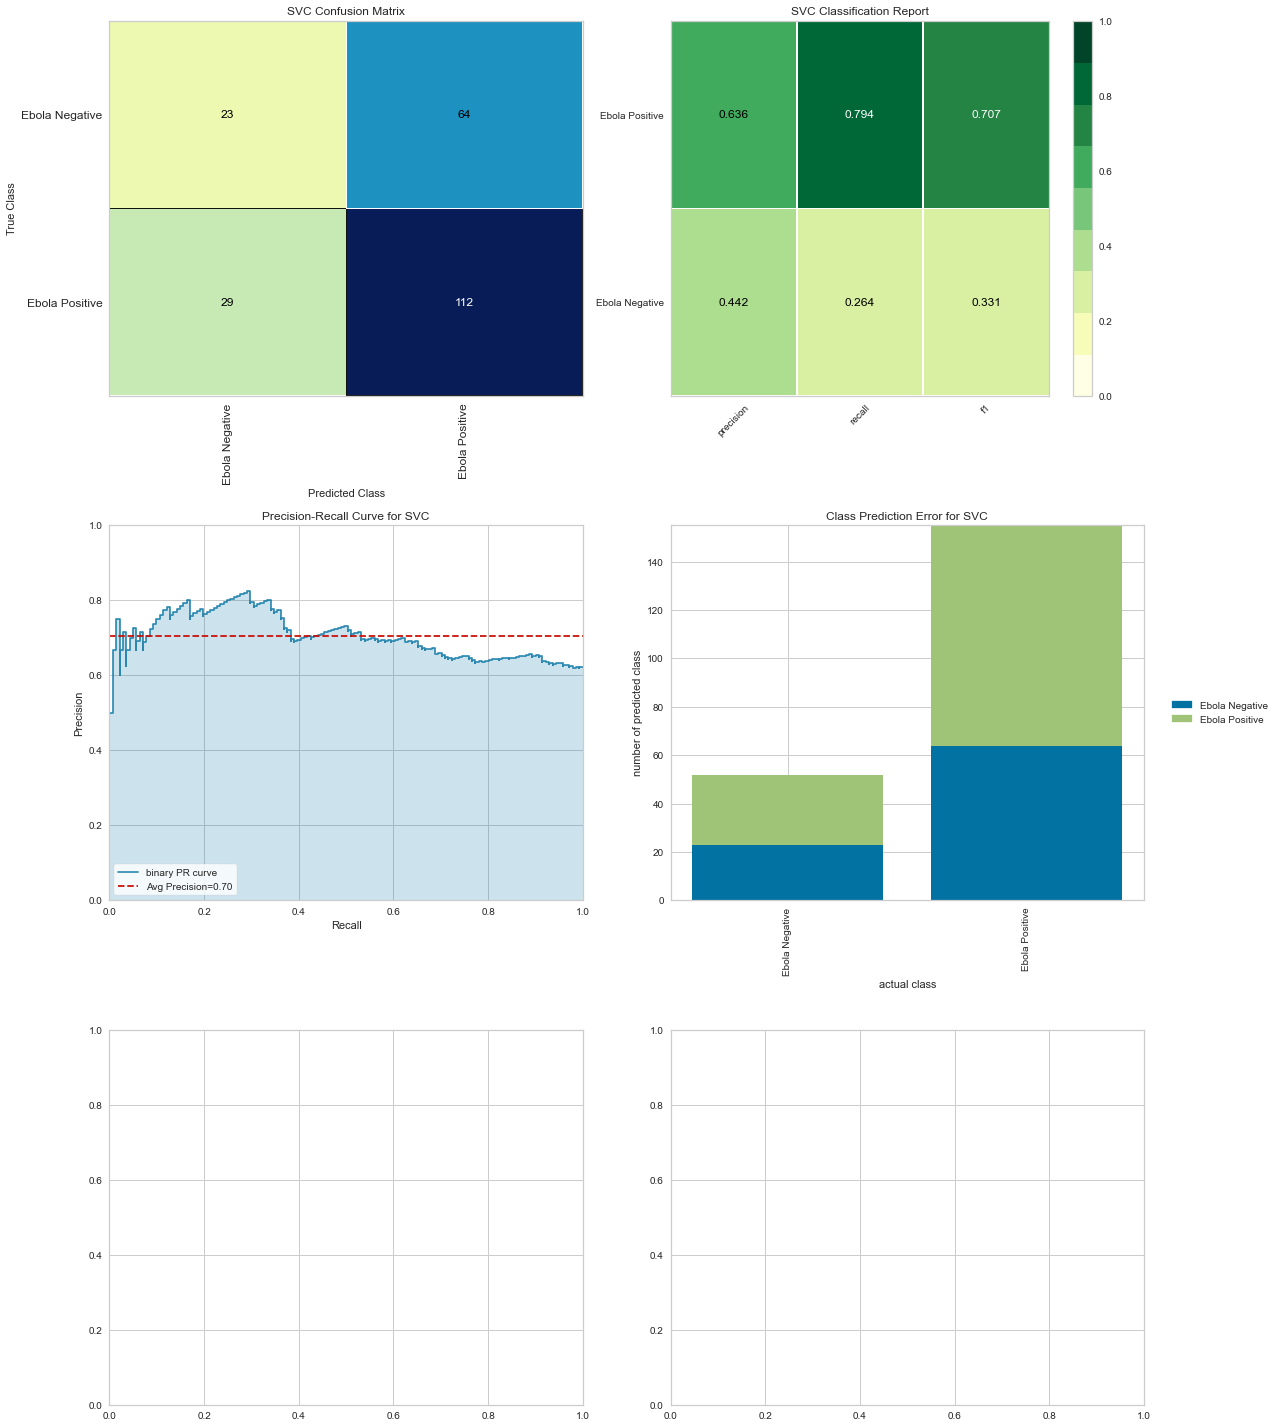

In [127]:
svc = svm.SVC(
    random_state=123,
    C= clf.best_params_['C'], 
    gamma = clf.best_params_['gamma'], 
    kernel = clf.best_params_['kernel']
)
score_model(X_out_train, y_out_train, X_out_test, y_out_test, svc)

### Logistic regression

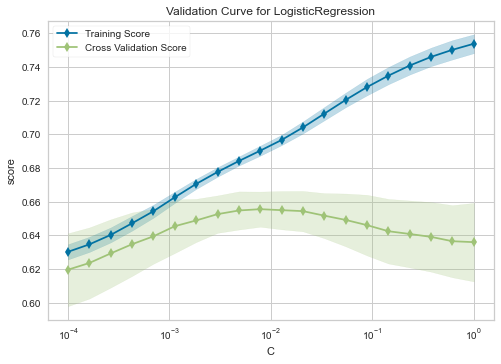

In [129]:
# Validation curve for C parameter 
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(LogisticRegression(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [130]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-3, -1, 30)}
logit = LogisticRegression(random_state=123)

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_out_train, y_out_train)

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.001     , 0...
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 

In [131]:
clf.best_params_

{'C': 0.1, 'penalty': 'l1'}

C:\Users\Cedric\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression:
On training we get an Accuracy 0.6336633663366337, an AUC 0.579376421414961 and F1 score 0.7320997586484312 
For test we get an Accuracy 0.5789473684210527, an AUC 0.520909757887014 and F1 score 0.6923076923076923


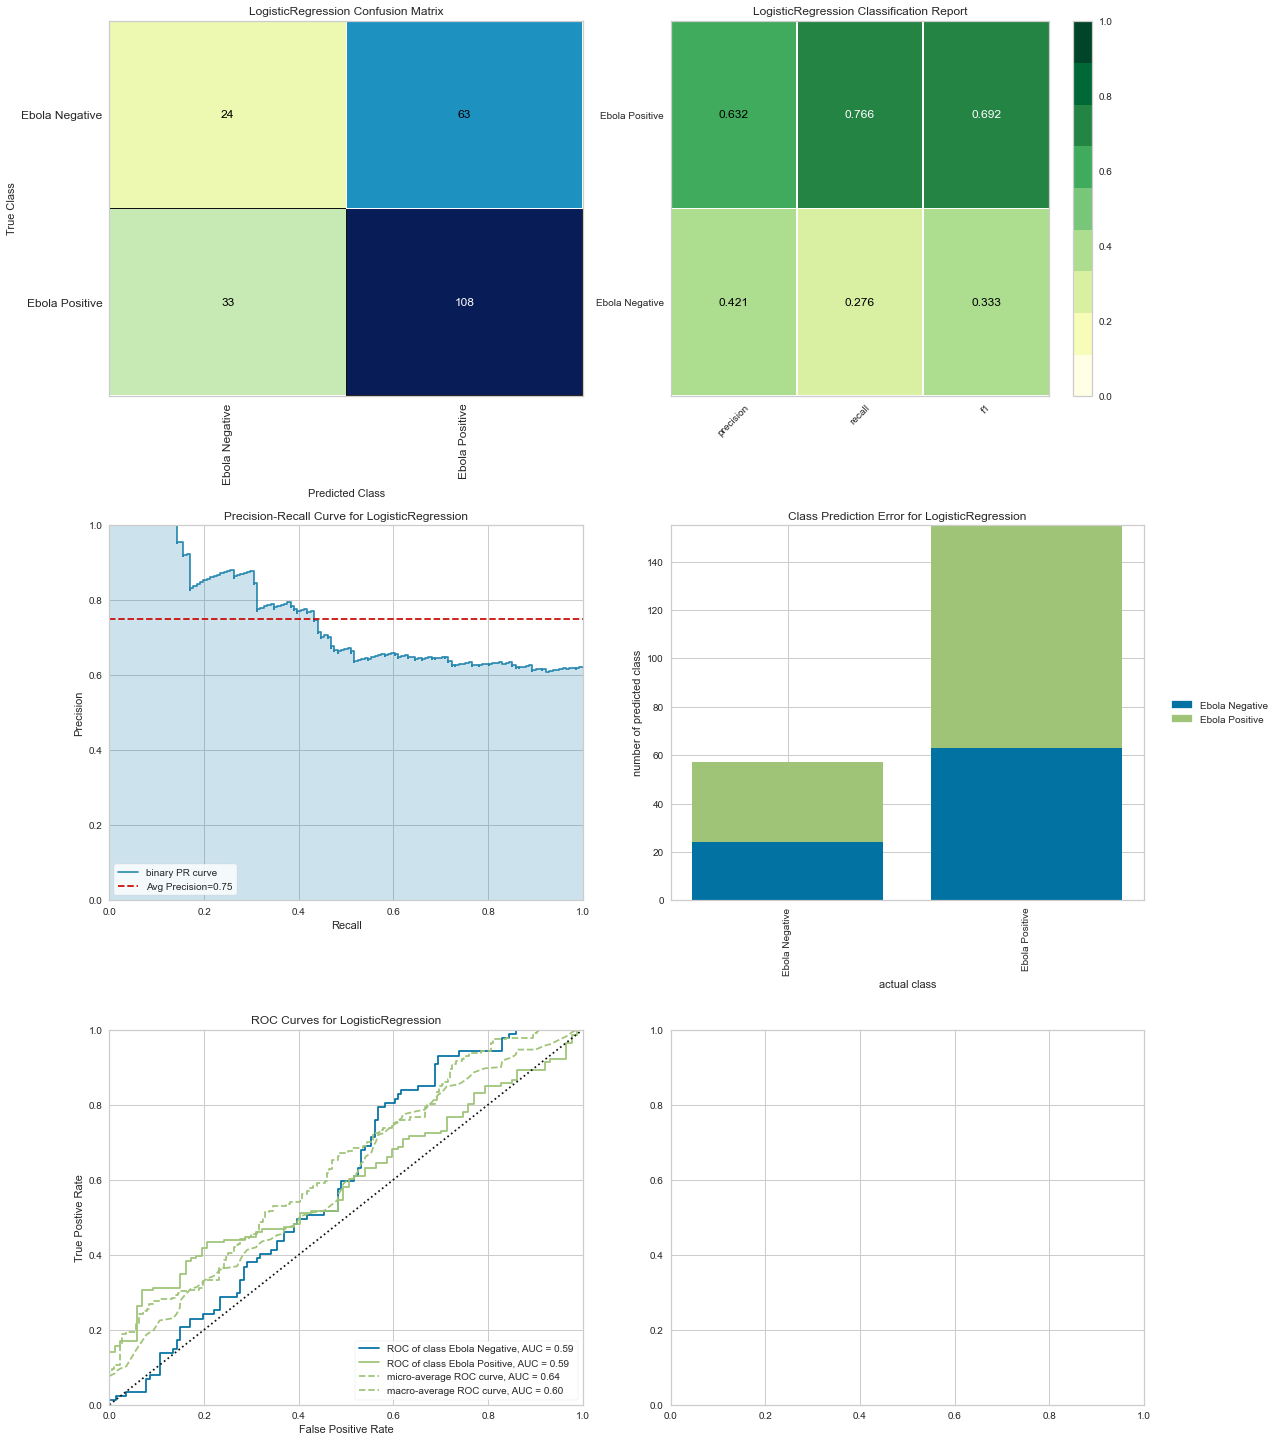

Don't have feature importance




In [132]:
logit = LogisticRegression(
    penalty = clf.best_params_['penalty'], 
    C = clf.best_params_['C']
)
score_model(X_out_train, y_out_train, X_out_test, y_out_test, logit)

### Random Forest

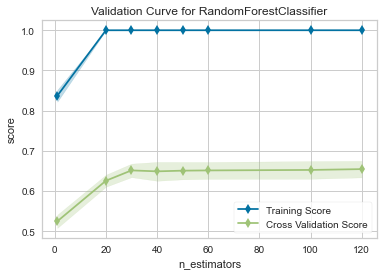

In [146]:
cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

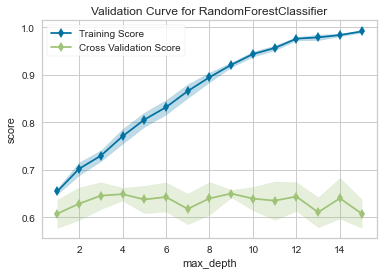

In [147]:
# For max_depth
param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

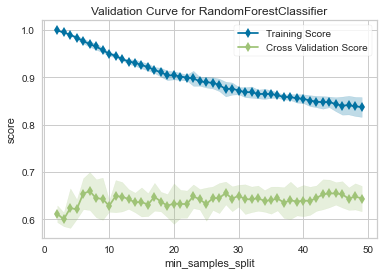

In [148]:
# For min_samples_split

param_range = range(2,50)

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

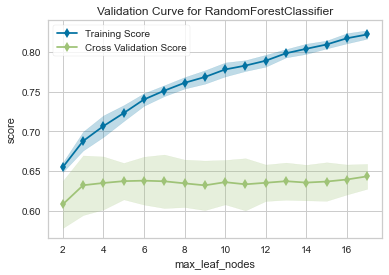

In [149]:
# For max_leaf_nodes
param_range = [2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15,16,17]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()


In [150]:
param_test = {
    'n_estimators':[30, 40, 50, 60, 100],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 5)],
    'max_leaf_nodes':[i for i in range(2, 17)]
}
clforest = RandomForestClassifier(random_state = 123)

In [151]:
gsearch = GridSearchCV(
    estimator= clforest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch.fit(X_out_train, y_out_train)
print(gsearch.best_params_)con

{'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_split': 3, 'n_estimators': 60}


In [152]:
clf_best = RandomForestClassifier(n_estimators=     gsearch.best_params_['n_estimators'], 
                                  max_depth=        gsearch.best_params_['max_depth'], 
                                  min_samples_split=gsearch.best_params_['min_samples_split'])
clf_best = clf_best.fit(X_out_train, y_out_train)
y_out_pred = clf_best.predict(X_out_test)
accuracy_all(y_out_test, y_out_pred)

Macro F1 score(test):  0.4741554741554742
Micro F1 score(test):  0.6271929824561403
Accuracy under curve(test):  0.529102470041575
